**GOAL** :

Use NLP to classify products.

- pre-process texts.
- generate features.
- project individuals into a 2D space with its label.
- cluster.
- compare results with ground truth labels.

*Note* :
Linda ensured I could use the data (no limiting copyrights)

**Table of contents**<a id='toc0_'></a>    
- 1. [Loading the data](#toc1_)    
- 2. [Extract relevant information.](#toc2_)    
  - 2.1. [How to assign a category to a product ?](#toc2_1_)    
- 3. [Discovering nltk](#toc3_)    
  - 3.1. [Effects on the name of the product](#toc3_1_)    
  - 3.2. [Effect on the name + description](#toc3_2_)    
- 4. [Product name tokenization and EDA](#toc4_)    
  - 4.1. [Occurrences - top words](#toc4_1_)    
  - 4.2. [Number of tokens in name](#toc4_2_)    
  - 4.3. [Top tokens per category](#toc4_3_)    
- 5. [Vectorization](#toc5_)    
  - 5.1. [Stemming to reduce the size of the vocabulary ?](#toc5_1_)    
    - 5.1.1. [Porter stemmer](#toc5_1_1_)    
    - 5.1.2. [Lancaster stemmer](#toc5_1_2_)    
  - 5.2. [Bag of words using tokens already generated directly in sklearn](#toc5_2_)    
  - 5.3. [Tf-idf vectorizer (using tokens)](#toc5_3_)    
- 6. [t-SNE embeddings of word-vectors.](#toc6_)    
  - 6.1. [Bags of words](#toc6_1_)    
  - 6.2. [Tf-idf](#toc6_2_)    
  - 6.3. [Both for visual comparison.](#toc6_3_)    
- 7. [ Clustering with Kmeans in word-vector-space and comparison with real classes.](#toc7_)    
- 8. [ Clustering with Kmeans in the t-sne space and comparison with real classes.](#toc8_)    
- 9. [LDA](#toc9_)    
- 10. [GMM on LDA projection](#toc10_)    
- 11. [Build an LDA dimensionality reduction based on partial information of classes (using CV), and then cluster in that space.](#toc11_)    
- 12. [Dimensionality reduction before t-SNE](#toc12_)    
  - 12.1. [PCA retaining 99% of the variance](#toc12_1_)    
    - 12.1.1. [Reduction](#toc12_1_1_)    
    - 12.1.2. [t-SNE](#toc12_1_2_)    
    - 12.1.3. [KMeans on t-SNE](#toc12_1_3_)    
    - 12.1.4. [GMM on t-SNE](#toc12_1_4_)    
    - 12.1.5. [Kmeans on the pca space](#toc12_1_5_)    
    - 12.1.6. [GMM on the PCA space](#toc12_1_6_)    
  - 12.2. [LSA + KMeans](#toc12_2_)    
- 13. [Conclusion on that notebook.](#toc13_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import project_tools as pt
import data_science_functions as ds

import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

# Define collection of words/tokens
stopwords = nltk.corpus.stopwords.words('english')
correct_words = set(nltk.corpus.words.words())
# Define lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# from sklearn.metrics import 

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/louberehc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/louberehc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/louberehc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/louberehc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Loading the data

In [2]:
text_data_path = 'data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'

In [3]:
df = pd.read_csv(text_data_path)
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"",

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

As I want to build a ML model to classify products into categories using NLP :
- Name and description seem interesting to be used as inputs.
- The product category tree will help in labeling.

There is no null is those columns.


In [5]:
df.product_name.head()

0         Elegance Polyester Multicolor Abstract Eyelet Door Curtain
1                                         Sathiyas Cotton Bath Towel
2                                Eurospa Cotton Terry Face Towel Set
3    SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet
4              Jaipur Print Cotton Floral King sized Double Bedsheet
Name: product_name, dtype: object

In [6]:
df.description.head()

0    Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Extract relevant information.

- Extract the product_name.
- Concatenate the name and the description of the product into the description column.
- Extract the product_id.
- Extract the product category.

I'd like to try to classify knowing only the name. And then, may be, I'll add the description.

In [7]:
df = pd.DataFrame(
    {
        'name' : df.product_name,
        'description' : df.product_name + '. ' + df.description,
        'product_id' : df.uniq_id,
        'product_category_tree' : df.product_category_tree,
    }
).set_index('product_id')
    
df.head(2)

,name,description,product_category_tree
product_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester","[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]"
7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel","[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]"


In [8]:
display(df.product_category_tree.head())

product_id
55b85ea15a1536d46b7190ad6fff8ce7                             ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
7b72c92c2f6c40268628ec5f14c6d590    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
64d5d4a258243731dc7bbb1eef49ad74     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
d4684dcdc759dd9cdf41504698d737d8      ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]
6325b6870c54cd47be6ebfbffa620ec7               ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]
Name: product_category_tree, dtype: object

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>How to assign a category to a product ?

Need to extract something relevant from product's category trees.

In [10]:
categories = df.product_category_tree.str.split(">>", expand=True)
categories = categories.rename(
    columns=(lambda x: f'level_{x}')
)
categories.head(5)

,level_0,level_1,level_2,level_3,level_4,level_5,level_6
product_id,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing",Curtains & Accessories,Curtains,"Elegance Polyester Multicolor Abstract Eyelet Do...""]",None,None,None
7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",None,None
64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,"Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",None,None
d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing",Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,"SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",None,None
6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing",Bed Linen,Bedsheets,Jaipur Print Bedsheets,"Jaipur Print Cotton Floral King sized Double Bed...""]",None,None


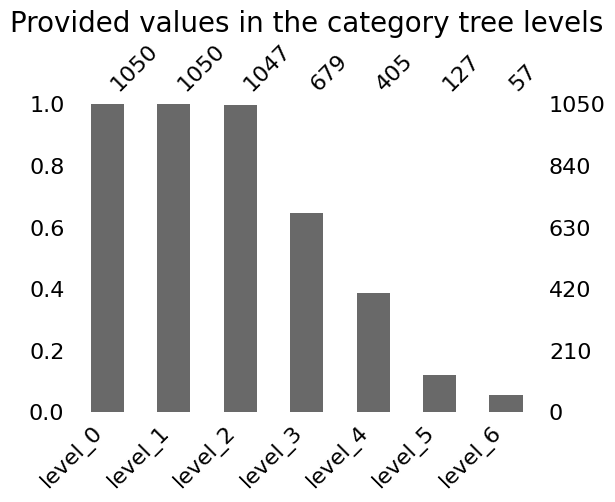

In [11]:
msno.bar(categories, figsize=(6, 4))
plt.title('Provided values in the category tree levels', fontsize=20)
plt.show()

A category is available for each product only in the 2 first columns.

In [13]:
categories.loc[:, 0].value_counts()

0
["Home Furnishing                150
["Baby Care                      150
["Watches                        150
["Home Decor & Festive Needs     150
["Kitchen & Dining               150
["Beauty and Personal Care       150
["Computers                      150
Name: count, dtype: int64

In [14]:
categories.loc[:, 1].value_counts()

1
 Wrist Watches                        149
 Laptop Accessories                    87
 Infant Wear                           84
 Coffee Mugs                           74
 Showpieces                            71
 Bed Linen                             65
 Fragrances                            65
 Network Components                    49
 Cookware                              27
 Table Decor & Handicrafts             27
 Combos and Kits                       24
 Wall Decor & Clocks                   22
 Bath Linen                            21
 Curtains & Accessories                19
 Makeup                                18
 Baby Bedding                          15
 Body and Skin Care                    15
 Baby & Kids Gifts                     15
 Baby Bath & Skin                      14
 Kitchen Tools                         14
 Kitchen & Dining Linen                14
 Decorative Lighting & Lamps           14
 Containers & Bottles                  13
 Cushions, Pillows & Covers     

In [15]:
len(categories.loc[:, 1].value_counts())

63

I choose to extract category from the first column (7 categories) because it is already to messy in the second column (63 categories).

By the way, let's not those categories are balanced (for supervised learning).

In [16]:
df['category'] = (
    categories
    .loc[:, 0]
    .str.removeprefix('["')
    .str.lower()
    .str.rstrip(' ')
    .str.replace(' ', '_')
)

df = df.drop('product_category_tree', axis=1)
                  
df.head(3)

,name,description,category
product_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing
7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care
64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"Eurospa Cotton Terry Face Towel Set. Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOWEL SET",baby_care


In [14]:
df.to_csv('text_data.csv.gz')

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Discovering nltk

In [15]:
# Load text data
df = pd.read_csv('text_data.csv.gz', index_col='product_id')
df.head(2)

,name,description,category
product_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing
7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care


## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Effects on the name of the product

In [16]:
name = df.name[100]
name

'Goldencollections GC4353 Makeup and Jewellery Vanity Pouch'

In [17]:
tokens = nltk.word_tokenize(name)
tokens

['Goldencollections',
 'GC4353',
 'Makeup',
 'and',
 'Jewellery',
 'Vanity',
 'Pouch']

In [18]:
# Retain only well-known words.
[token for token in tokens if token.lower() in correct_words]

['and', 'Vanity', 'Pouch']

This filter is too strong because of the misspelling.

In [36]:
[token for token in correct_words if token.startswith('jewel')]

['jewely',
 'jewellike',
 'jeweling',
 'jeweler',
 'jewel',
 'jewelry',
 'jewelweed',
 'jewelsmith',
 'jewelless',
 'jewelhouse']

In [19]:
# Trying a spell corrector found on the web.
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

In [20]:
for word in tokens:
    temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==word[0]]
    print(sorted(temp, key = lambda val:val[0])[0][1])

Goldenmouth
Galliformes
Maku
and
Jewry
Vanir
Pluchea


Not working either.

If I want to make things right, I should probably conceive a list of probable and helpful classification words occurring in the products name, and compute distances of unknown words to this list to find the closest, and map it. 

That would be a lot of work. 

In [21]:
[lemmatizer.lemmatize(token.lower()) for token in tokens]

['goldencollections',
 'gc4353',
 'makeup',
 'and',
 'jewellery',
 'vanity',
 'pouch']

In [22]:
[word for word in correct_words if word.startswith('make')]

['makeshifty',
 'makeshift',
 'make',
 'makership',
 'makeshiftiness',
 'makeshiftness',
 'makeress',
 'makedom',
 'makeweight',
 'makebate',
 'makefast',
 'maker']

In [23]:
from nltk.stem import PorterStemmer

In [24]:
stemmer = PorterStemmer()

In [25]:
[stemmer.stem(token) for token in tokens]

['goldencollect', 'gc4353', 'makeup', 'and', 'jewelleri', 'vaniti', 'pouch']

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a>Effect on the name + description

In [26]:
desc = df.description[100]
desc

'Goldencollections GC4353 Makeup and Jewellery Vanity Pouch. Buy Goldencollections GC4353 Makeup and Jewellery Vanity Pouch for Rs.783 online. Goldencollections GC4353 Makeup and Jewellery Vanity Pouch at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.'

In [27]:
tokens = nltk.word_tokenize(desc)
tokens

['Goldencollections',
 'GC4353',
 'Makeup',
 'and',
 'Jewellery',
 'Vanity',
 'Pouch',
 '.',
 'Buy',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'and',
 'Jewellery',
 'Vanity',
 'Pouch',
 'for',
 'Rs.783',
 'online',
 '.',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'and',
 'Jewellery',
 'Vanity',
 'Pouch',
 'at',
 'best',
 'prices',
 'with',
 'FREE',
 'shipping',
 '&',
 'cash',
 'on',
 'delivery',
 '.',
 'Only',
 'Genuine',
 'Products',
 '.',
 '30',
 'Day',
 'Replacement',
 'Guarantee',
 '.']

In [28]:
cleaned_tokens = [token for token in tokens if token.lower() not in stopwords]
cleaned_tokens

['Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 '.',
 'Buy',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 'Rs.783',
 'online',
 '.',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 'best',
 'prices',
 'FREE',
 'shipping',
 '&',
 'cash',
 'delivery',
 '.',
 'Genuine',
 'Products',
 '.',
 '30',
 'Day',
 'Replacement',
 'Guarantee',
 '.']

In [29]:
# Test lemmatize effect.
sentence = nltk.word_tokenize('woman women buying mice')
[lemmatizer.lemmatize(word) for word in sentence]

['woman', 'woman', 'buying', 'mouse']

In [30]:
[lemmatizer.lemmatize(token) for token in cleaned_tokens]

['Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 '.',
 'Buy',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 'Rs.783',
 'online',
 '.',
 'Goldencollections',
 'GC4353',
 'Makeup',
 'Jewellery',
 'Vanity',
 'Pouch',
 'best',
 'price',
 'FREE',
 'shipping',
 '&',
 'cash',
 'delivery',
 '.',
 'Genuine',
 'Products',
 '.',
 '30',
 'Day',
 'Replacement',
 'Guarantee',
 '.']

In [31]:
tagged = nltk.pos_tag(tokens)
tagged

[('Goldencollections', 'NNS'),
 ('GC4353', 'NNP'),
 ('Makeup', 'NNP'),
 ('and', 'CC'),
 ('Jewellery', 'NNP'),
 ('Vanity', 'NNP'),
 ('Pouch', 'NNP'),
 ('.', '.'),
 ('Buy', 'NNP'),
 ('Goldencollections', 'NNP'),
 ('GC4353', 'NNP'),
 ('Makeup', 'NNP'),
 ('and', 'CC'),
 ('Jewellery', 'NNP'),
 ('Vanity', 'NNP'),
 ('Pouch', 'NNP'),
 ('for', 'IN'),
 ('Rs.783', 'NNP'),
 ('online', 'NN'),
 ('.', '.'),
 ('Goldencollections', 'NNP'),
 ('GC4353', 'NNP'),
 ('Makeup', 'NNP'),
 ('and', 'CC'),
 ('Jewellery', 'NNP'),
 ('Vanity', 'NNP'),
 ('Pouch', 'NNP'),
 ('at', 'IN'),
 ('best', 'JJS'),
 ('prices', 'NNS'),
 ('with', 'IN'),
 ('FREE', 'NNP'),
 ('shipping', 'VBG'),
 ('&', 'CC'),
 ('cash', 'NN'),
 ('on', 'IN'),
 ('delivery', 'NN'),
 ('.', '.'),
 ('Only', 'RB'),
 ('Genuine', 'JJ'),
 ('Products', 'NNPS'),
 ('.', '.'),
 ('30', 'CD'),
 ('Day', 'NNP'),
 ('Replacement', 'NNP'),
 ('Guarantee', 'NNP'),
 ('.', '.')]

In [32]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Goldencollections/NNS
  (ORGANIZATION GC4353/NNP Makeup/NNP)
  and/CC
  (PERSON Jewellery/NNP Vanity/NNP Pouch/NNP)
  ./.
  (PERSON Buy/NNP Goldencollections/NNP)
  GC4353/NNP
  Makeup/NNP
  and/CC
  (PERSON Jewellery/NNP Vanity/NNP Pouch/NNP)
  for/IN
  Rs.783/NNP
  online/NN
  ./.
  (PERSON Goldencollections/NNP GC4353/NNP Makeup/NNP)
  and/CC
  (PERSON Jewellery/NNP Vanity/NNP Pouch/NNP)
  at/IN
  best/JJS
  prices/NNS
  with/IN
  (ORGANIZATION FREE/NNP)
  shipping/VBG
  &/CC
  cash/NN
  on/IN
  delivery/NN
  ./.
  Only/RB
  (ORGANIZATION Genuine/JJ Products/NNPS)
  ./.
  30/CD
  Day/NNP
  Replacement/NNP
  Guarantee/NNP
  ./.)


# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Product name tokenization and EDA

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Occurrences - top words

In [137]:
# Tokenize and concatenate all product names in a Series. 
# Afterwards, count each occurence in it.
token_occurrences = pd.Series(
    
    df.name
    .str.lower()
    .apply(nltk.word_tokenize)
    .sum()
    
).value_counts()

# a df with 2 columns (token, count)
token_occurrences = pd.DataFrame(token_occurrences).reset_index(names='token')

token_occurrences.head(50)

,token,count
0,-,286
1,for,169
2,watch,150
3,set,134
4,analog,127
5,",",111
6,cm,109
7,showpiece,105
8,baby,94
9,combo,93


I want to filter useless tokens such as punctuation.

Maybe I'll also try to filter on small tokens (less than 2 char to see if it improves classification task later.

In [138]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [139]:
useless_tokens = ["'s", "''"]


undesired_tokens = [*useless_tokens,
                    *string.punctuation,
                    *stopwords,]

final_tokens = [token 
                for token in token_occurrences.token
                if token not in undesired_tokens]

final_tokens[:30]

#remark : this as been implemented in the pt.tokenize_product_name function

['watch',
 'set',
 'analog',
 'cm',
 'showpiece',
 'baby',
 'combo',
 'men',
 'ceramic',
 'mug',
 'usb',
 'cotton',
 'women',
 'girl',
 'single',
 'double',
 'laptop',
 'abstract',
 'boys',
 'boy',
 'blue',
 'led',
 'printed',
 'multicolor',
 '6',
 'floral',
 'design',
 'blanket',
 'black',
 'prithish']

In [140]:
[token for token in final_tokens if not token.isalnum()]

['vitamin-e',
 't-shirt',
 '19.5v,3.9a',
 'party-wedding',
 'wi-fi',
 'a-line',
 'analog-digital',
 'd-link',
 'pa+',
 'tp-link',
 '10.5',
 '3.5',
 '4-port',
 'dual-band',
 '6.5',
 'techone+',
 '1.5',
 '7.62',
 'pc-122',
 '20.5',
 '2.3',
 '2.5',
 '3.8',
 '4.5',
 '30.48',
 '1.2',
 'pa+++',
 'pa++',
 '17.6',
 '4gb/',
 '1tb/',
 '1.47m',
 "'m",
 '8.89',
 '50.8',
 '21.59',
 'abkl_grn_grn_grn',
 'pc-301',
 'life-is-not-living',
 'figh_008',
 'keep-calm',
 'abkl_pl_pl_pnk',
 'league-of-legends',
 'abkl_pl_pnk_pnk',
 '3003-pk',
 'mb990ll/a',
 '13.3',
 'mb990hn/a',
 'anti-dust',
 'i-loves-music',
 'i-love-my-mom',
 'pc-303',
 'pc-310',
 'vgn-nw270db_90',
 'r.s',
 'bw-prsmd',
 "d'signer",
 '8502-7purple',
 'st.',
 '101-107',
 '34.29',
 'g6-1241ea',
 'g6-1240sg',
 'bathmat_ri-527',
 'ducjug010-ducgl012-2',
 'cnl-50-white-rg',
 'pcc-501c',
 '681gm_wht',
 'pc-414w',
 'pc-218',
 'set-pleasing',
 '3-pc',
 'pc-126',
 'pc-222',
 '27.9',
 '7.5',
 '49.5',
 '3.4',
 '3.2',
 'gel-cream',
 'roche-posay',
 's

TODO ?

Some formats can possibly be extracted from here with regexp and mapped to a unique category. 

For example, all 'vgn-crxxxx' are probably the same kind of object. 

In [141]:
top_tokens = final_tokens[:50]
print(top_tokens)
token_occurrences = token_occurrences.query('token in @final_tokens')

['watch', 'set', 'analog', 'cm', 'showpiece', 'baby', 'combo', 'men', 'ceramic', 'mug', 'usb', 'cotton', 'women', 'girl', 'single', 'double', 'laptop', 'abstract', 'boys', 'boy', 'blue', 'led', 'printed', 'multicolor', '6', 'floral', 'design', 'blanket', 'black', 'prithish', 'cell', 'l', 'cover', 'sticker', 'print', 'light', 'towel', 'maxima', 'sonata', 'rockmantra', 'kadhai', 'dress', 'battery', 'gold', 'polyester', 'quilts', 'comforters', 'red', 'gift', 'curtain']


In [142]:
token_occurrences.query('count > 1')

,token,count
2,watch,150
3,set,134
4,analog,127
6,cm,109
7,showpiece,105
...,...,...
786,copper,2
787,hot,2
788,1038,2
789,smooth,2


755 relevant tokens appear more than once.

'Watch' presence will be an excellent classifier, but a lot of words will only appear once.

In [143]:
example_name = df.iloc[22, 0]
example_name

'Franck Bella FB127A Analog Watch  - For Boys, Men'

In [144]:
pt.tokenize_product_name(example_name)

['franck', 'bella', 'fb127a', 'analog', 'watch', 'boy', 'men']

In [145]:
example_name = df.iloc[43, 0]
example_name

'Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner'

In [146]:
pt.tokenize_product_name(example_name)

['burt', 'bee', 'hair', 'repair', 'shea', 'grapefruit', 'deep', 'conditioner']

In [147]:
df['name_tokens'] = df.name.apply(pt.tokenize_product_name)

In [148]:
df[['name','name_tokens']].sample(10)

,name,name_tokens
product_id,,
cf03921bd7eb3afd84c4b12a434d03e5,"Pinc Ginger 90.6 inch Black, White Rice Lights","[pinc, ginger, 90.6, inch, black, white, rice, light]"
862c7462f12de819d93f93dc573289c5,Nike Orange Combo Set,"[nike, orange, combo, set]"
63f2d92a3f5fc6cfc11e7f99d5798eac,Services Junction Beautiful Black and Golden color Diamond Ganesh idol for Pooja Showpiece - 5 cm,"[service, junction, beautiful, black, golden, color, diamond, ganesh, idol, pooja, showpiece, 5, cm]"
4354b7418ee0fab2fd9f8eb493556529,Memore Portable and Flexible MMULL-White USB Led Light,"[memore, portable, flexible, mmull-white, usb, led, light]"
f74476ba64365d97a5be7d375cbf4c7a,Now SP-ETHNIC Analog Watch - For Boys,"[sp-ethnic, analog, watch, boy]"
b362b56f7ee80dcfe9d8bb643df87007,eCraftIndia Analog 2.5 cm Dia Wall Clock,"[ecraftindia, analog, 2.5, cm, dia, wall, clock]"
bbb8cdc5406ff60ff06ff64630f2ca47,"Srushti Art Jewelry Megnet_Led_Sport_BlackRed1 Digital Watch - For Men, Women, Boys, Girls","[srushti, art, jewelry, megnet_led_sport_blackred1, digital, watch, men, woman, boy, girl]"
156bcd3aba1838a2b6bad856654db964,Timewel N1536(GW)_1 Analog Watch - For Men,"[timewel, n1536, gw, _1, analog, watch, men]"
894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girls","[kidz, 20600, digital, watch, boy, girl]"


satisfying result for now.

In [149]:
df.head(2)

,name,description,category,name_tokens,n_tokens_in_name
product_id,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing,"[elegance, polyester, multicolor, abstract, eyelet, door, curtain]",7
7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care,"[sathiyas, cotton, bath, towel]",4


In [150]:
df.to_csv('text_data_plus_name_tokens.csv.gz')

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Number of tokens in name

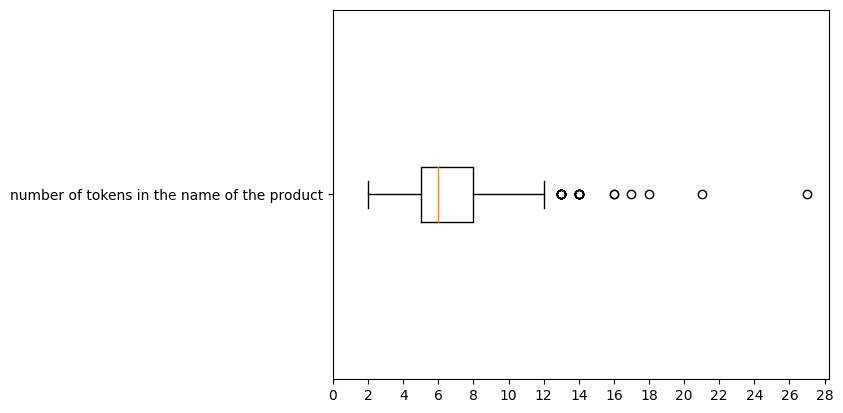

In [151]:
df['n_tokens_in_name'] = df.name_tokens.apply(lambda x: len(x))
plt.boxplot(
    df.n_tokens_in_name,
    vert=False,
    labels=['number of tokens in the name of the product'],
)
plt.xticks(np.arange(0, df.n_tokens_in_name.max()+3, 2))
plt.show()

In [152]:
df.query('n_tokens_in_name > 20')

,name,description,category,name_tokens,n_tokens_in_name
product_id,,,,,
799ddb97164ff2d5d53bb8b27b8c355f,"Indian Art Villa 2.3"" X 6.9"" X 2.3"" Handmade High Quality Stainless Steel Copper Dish Serving Indian Food Daal Curry Karahi Kadai Wok Bowl Kadhai 0.7 L","Indian Art Villa 2.3"" X 6.9"" X 2.3"" Handmade High Quality Stainless Steel Copper Dish Serving Indian Food Daal Curry Karahi Kadai Wok Bowl Kadhai 0.7 L. Buy Indian Art Villa 2.3"" X 6.9"" X 2.3"" Handmade High Quality Stainless Steel Copper Dish Serving Indian Food Daal Curry Karahi Kadai Wok Bowl Kadhai 0.7 L for Rs.750 online. Indian Art Villa 2.3"" X 6.9"" X 2.3"" Handmade High Quality Stainless Steel Copper Dish Serving Indian Food Daal Curry Karahi Kadai Wok Bowl Kadhai 0.7 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.",kitchen_&_dining,"[indian, art, villa, 2.3, x, 6.9, x, 2.3, handmade, high, quality, stainless, steel, copper, dish, serving, indian, food, daal, curry, karahi, kadai, wok, bowl, kadhai, 0.7, l]",27
7cdc62f8d3f7ab8b9d2dddc14c86de83,"Akshaj Lightweight Flexible Portable Adjustable With 50000 Hours Life For Keyboard Laptop Pc Notebook Power Bank, Book Reading Work Bed USB Led Light","Akshaj Lightweight Flexible Portable Adjustable With 50000 Hours Life For Keyboard Laptop Pc Notebook Power Bank, Book Reading Work Bed USB Led Light. Buy Akshaj Lightweight Flexible Portable Adjustable With 50000 Hours Life For Keyboard Laptop Pc Notebook Power Bank, Book Reading Work Bed USB Led Light for Rs.199 online. Akshaj Lightweight Flexible Portable Adjustable With 50000 Hours Life For Keyboard Laptop Pc Notebook Power Bank, Book Reading Work Bed USB Led Light at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.",computers,"[akshaj, lightweight, flexible, portable, adjustable, 50000, hour, life, keyboard, laptop, pc, notebook, power, bank, book, reading, work, bed, usb, led, light]",21


In [154]:
print(len(df.query('n_tokens_in_name == 2')))
df.query('n_tokens_in_name == 2').sample(5)

36


,name,description,category,name_tokens,n_tokens_in_name
product_id,,,,,
d1899ab1d5c79ddaa311bc9f04d198ed,D-Link DAP1320,"D-Link DAP1320. Key Features of D-Link DAP1320 QRS app(iOS,Android),Specifications of D-Link DAP1320 (White) Speed Wireless Speed 300 Mbps DSL Modem Speed 300 Mbps General Brand D-Link In The Box Extender Plug Model DAP1320 Type Range Extenders/Repeaters Color White Warranty Covered in Warranty No damage Warranty Summary 3years Service Type No damage Not Covered in Warranty damaged will not repair Dimensions Weight 69 g Connectivity Number of Antennae 2 Number of USB Ports 0 Antennae Internal Supported Protocols Standard IEEE IEEE 802.11n/g/b Operating Conditions Operating Humidity Operating: 10% to 90% non-condensing // Storage: 5% to 95% non-condensing Temperature Operating: 0 to 40 °C (32 to 104 °F)//Storage: -20 to 65 °C (-4 to 149 °F) degree C Additional Features Certification FCC, IC, CE",computers,"[d-link, dap1320]",2
d36e6f157d1155369f763a0a434fb129,Digisol DG-BG4100N,Digisol DG-BG4100N. Buy Digisol DG-BG4100N only for Rs. 1470 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!,computers,"[digisol, dg-bg4100n]",2
9a993e1b59649c93f667d38227325066,Edimax AR-7286WNA,Edimax AR-7286WNA. Buy Edimax AR-7286WNA only for Rs. 2445 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!,computers,"[edimax, ar-7286wna]",2
53c4f1e5cb1767f1a6ba05d32dfaf107,Tenda 3G300M,Tenda 3G300M. Buy Tenda 3G300M only for Rs. 3000 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!,computers,"[tenda, 3g300m]",2
3aaa50eb5d2cf4c18b57346423871624,Portia Hat,"Portia Hat. Specifications of Portia Hat (Pink, Pack of 1) In The Box Number of Contents in Sales Package Pack of 1 General Ideal For Girls",baby_care,"[portia, hat]",2


Indeed, it will be important to catch those kind of formats at some point.
Especially for those laconic names.

## 4.3.  [&#9650;](#toc0_) <a id='toc4_3_'></a>Top tokens per category

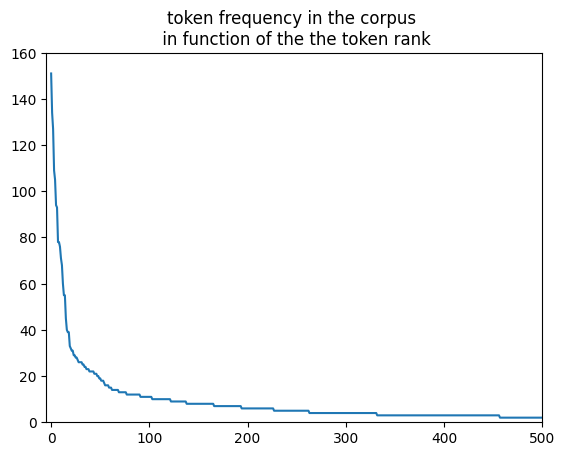

In [174]:
token_counts = pt.make_tokens_count(df, 'name_tokens')
plt.plot(token_counts.index, token_counts['count'])
plt.axis([-5, 500, 0, 160])
plt.title('token frequency in the corpus \n in function of the the token rank')
plt.show()

In [181]:
# find abscissa of changes above
for k in range(2,10):
    print(f'threshold occurrences = {k}')
    print(f'n_tokens : {token_counts.query("count >= @k").shape[0]}')    


threshold occurrences = 2
n_tokens : 744
threshold occurrences = 3
n_tokens : 457
threshold occurrences = 4
n_tokens : 332
threshold occurrences = 5
n_tokens : 263
threshold occurrences = 6
n_tokens : 227
threshold occurrences = 7
n_tokens : 194
threshold occurrences = 8
n_tokens : 166
threshold occurrences = 9
n_tokens : 138


*****
baby_care


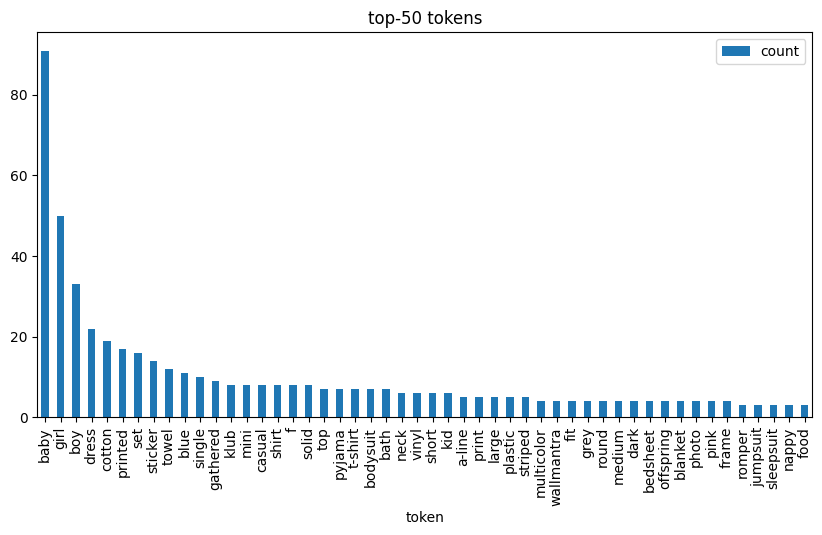

*****
beauty_and_personal_care


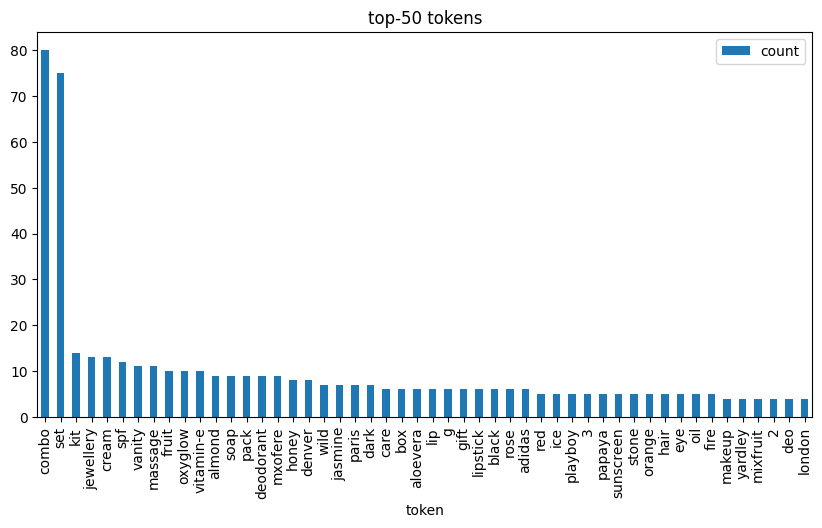

*****
computers


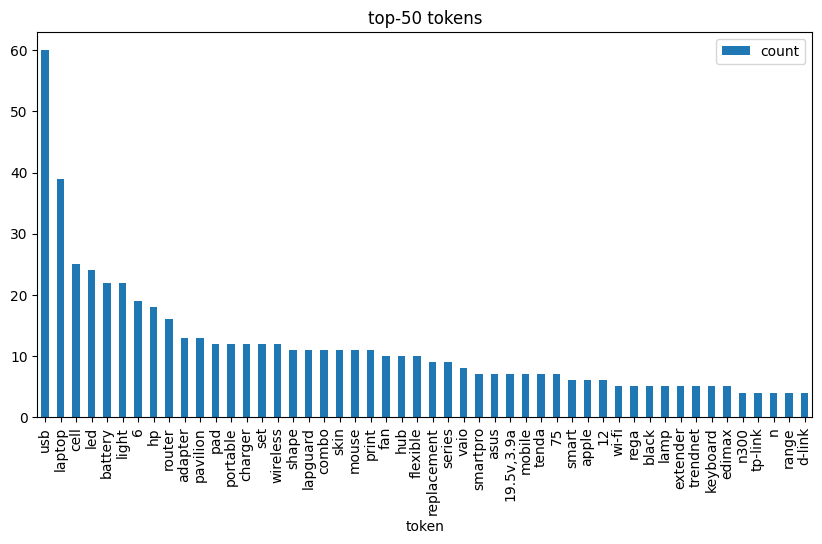

*****
home_decor_&_festive_needs


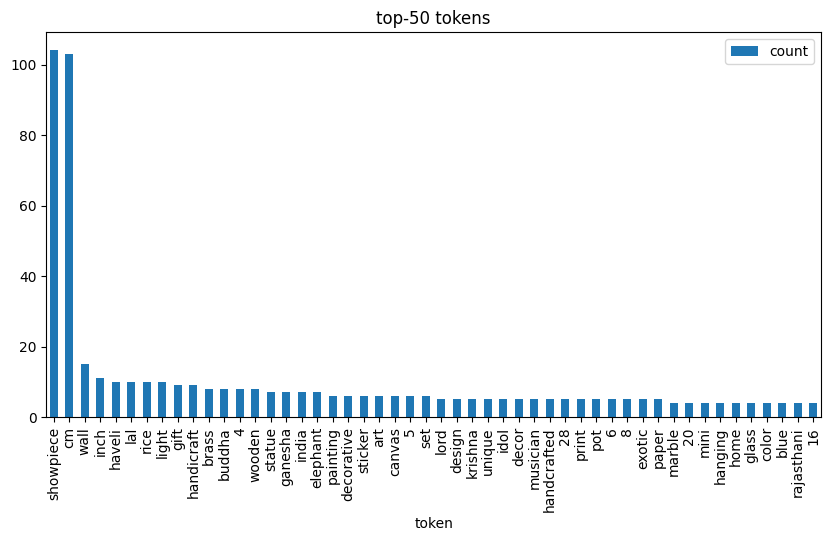

*****
home_furnishing


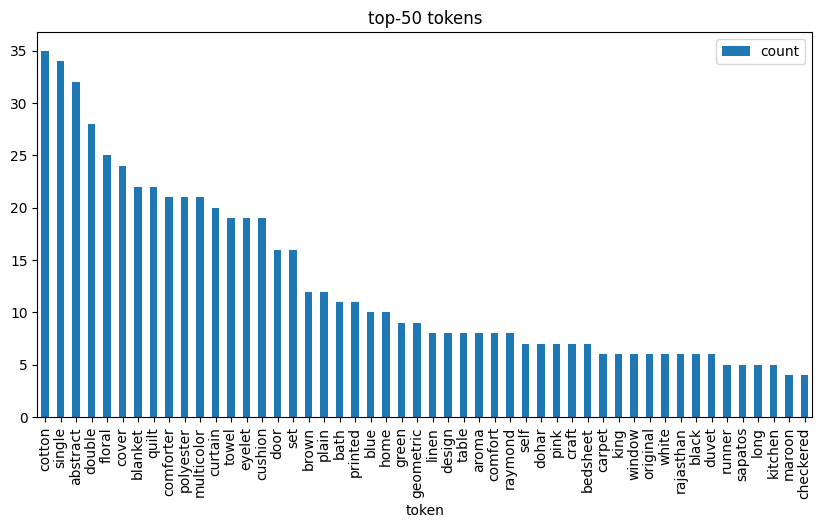

*****
kitchen_&_dining


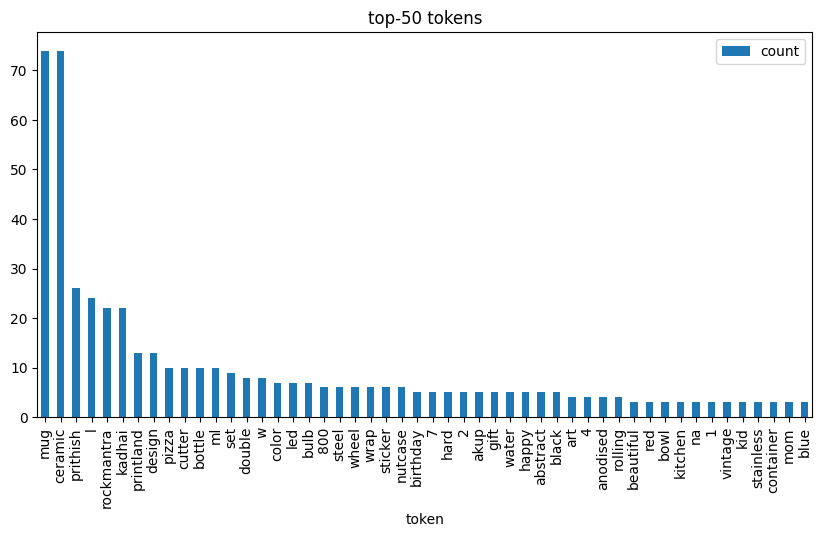

*****
watches


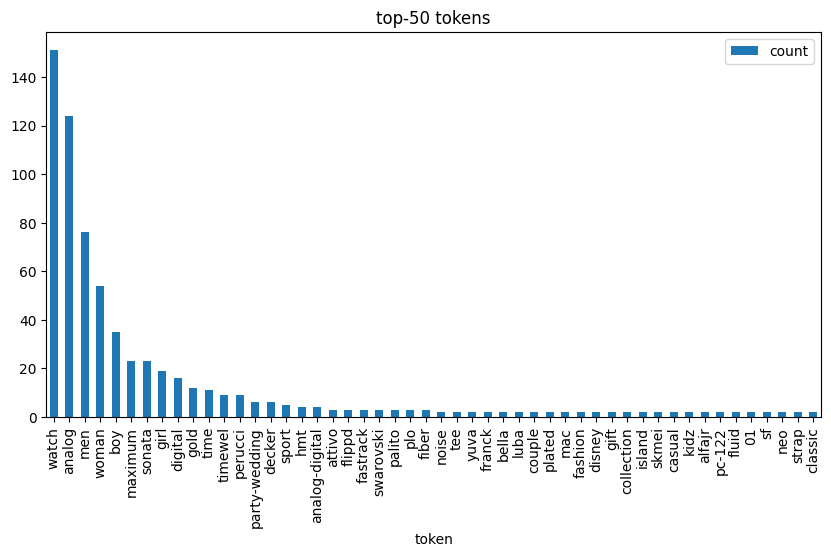

In [183]:
for group_name, group in df.groupby('category').__iter__():
    print('*****')
    print(group_name)
    # display top tokens
    _ = pt.find_top_tokens(
        group, 'name_tokens', n_top=50, n_display=50, display=True
    )
    # display 

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Vectorization

In [2]:
df = pd.read_csv('text_data_plus_name_tokens.csv.gz', index_col='product_id')
# To ensure that the columns contains list of tokens
# and not a string of the list of tokens.
df['name_tokens'] = df.name_tokens.apply(lambda x: eval(x))

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Stemming to reduce the size of the vocabulary ?

In [57]:
example = df.name_tokens[78]
example

['jaipur', 'print', 'cotton', 'floral', 'diwan', 'set']

In [58]:
[stemmer.stem(token) for token in example]

['jaipur', 'print', 'cotton', 'floral', 'diwan', 'set']

### 5.1.1.  [&#9650;](#toc0_) <a id='toc5_1_1_'></a>Porter stemmer

In [63]:
for k in range(30):
    tokens = df.name_tokens[k]
    if tokens != [porter.stem(token) for token in tokens]:
        print('*****')
        print(tokens)
        print([porter.stem(token) for token in tokens])

*****
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain']
['eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain']
*****
['sathiyas', 'cotton', 'bath', 'towel']
['sathiya', 'cotton', 'bath', 'towel']
*****
['eurospa', 'cotton', 'terry', 'face', 'towel', 'set']
['eurospa', 'cotton', 'terri', 'face', 'towel', 'set']
*****
['santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet']
['santosh', 'royal', 'fashion', 'cotton', 'print', 'king', 'size', 'doubl', 'bedsheet']
*****
['jaipur', 'print', 'cotton', 'floral', 'king', 'sized', 'double', 'bedsheet']
['jaipur', 'print', 'cotton', 'floral', 'king', 'size', 'doubl', 'bedsheet']
*****
['camerii', 'wm64', 'elegance', 'analog', 'watch', 'men', 'boy']
['camerii', 'wm64', 'eleg', 'analog', 'watch', 'men', 'boy']
*****
['alfajr', 'wy16b', 'youth', 'digital', 'watch', 'men', 'boy']
['alfajr', 'wy16b', 'youth', 'digit', 'watch', 'men', 'boy']
*****
['calibro', 'sw-125',

### 5.1.2.  [&#9650;](#toc0_) <a id='toc5_1_2_'></a>Lancaster stemmer

In [64]:
for k in range(30):
    tokens = df.name_tokens[k]
    if tokens != [lancaster.stem(token) for token in tokens]:
        print('*****')
        print(tokens)
        print([lancaster.stem(token) for token in tokens])

*****
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain']
['eleg', 'polyest', 'multicol', 'abstract', 'eyelet', 'door', 'curtain']
*****
['sathiyas', 'cotton', 'bath', 'towel']
['sathiya', 'cotton', 'bath', 'towel']
*****
['eurospa', 'cotton', 'terry', 'face', 'towel', 'set']
['eurosp', 'cotton', 'terry', 'fac', 'towel', 'set']
*****
['santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet']
['santosh', 'roy', 'fash', 'cotton', 'print', 'king', 'siz', 'doubl', 'bedsheet']
*****
['jaipur', 'print', 'cotton', 'floral', 'king', 'sized', 'double', 'bedsheet']
['jaip', 'print', 'cotton', 'flor', 'king', 'siz', 'doubl', 'bedsheet']
*****
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy']
['maserat', 'tim', 'r8851116001', 'analog', 'watch', 'boy']
*****
['camerii', 'wm64', 'elegance', 'analog', 'watch', 'men', 'boy']
['cameri', 'wm64', 'eleg', 'analog', 'watch', 'men', 'boy']
*****
['alfajr', 'wy16b', 'youth', 'digital',

None of these stemmers seem to decrease with relevancy the size of the vocabulary. I'll do the bag of words without stemming.

## 5.2.  [&#9650;](#toc0_) <a id='toc5_2_'></a>Bag of words using tokens already generated directly in sklearn

In [3]:
df.name_tokens.head().values

array([list(['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain']),
       list(['sathiyas', 'cotton', 'bath', 'towel']),
       list(['eurospa', 'cotton', 'terry', 'face', 'towel', 'set']),
       list(['santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet']),
       list(['jaipur', 'print', 'cotton', 'floral', 'king', 'sized', 'double', 'bedsheet'])],
      dtype=object)

In [3]:
# Create a dummy function to do nothing in the pre-processing
# and tokenizing steps as it is already done.
def dummy_fun(doc):
    return doc

vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

X_bow = vectorizer.fit_transform(list(df.name_tokens))

In [26]:
X_bow.shape

(1050, 2292)

## 5.3.  [&#9650;](#toc0_) <a id='toc5_3_'></a>Tf-idf vectorizer (using tokens)

In [4]:
# Create a dummy function to do nothing in the pre-processing
# and tokenizing steps as it is already done.
def dummy_fun(doc):
    return doc

vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

X_tf_idf = vectorizer.fit_transform(df.name_tokens)

In [28]:
X_tf_idf.shape

(1050, 2292)

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>t-SNE embeddings of word-vectors.

## 6.1.  [&#9650;](#toc0_) <a id='toc6_1_'></a>Bags of words

15
30
50
70
85
100


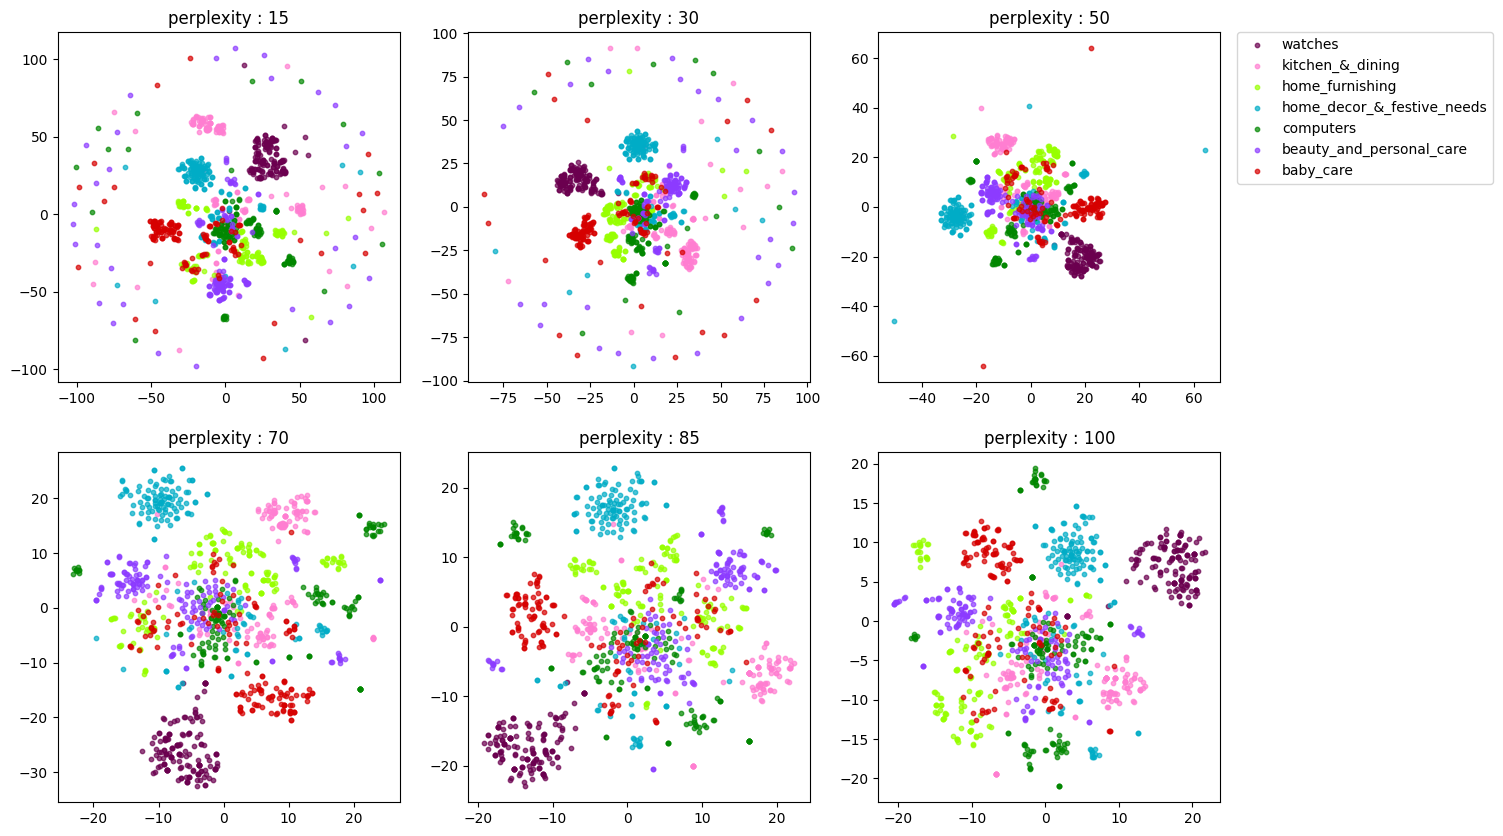

In [ ]:
ds.find_tsne_best_perplexity(X_bow, labels=df.category, tsne_init='random')

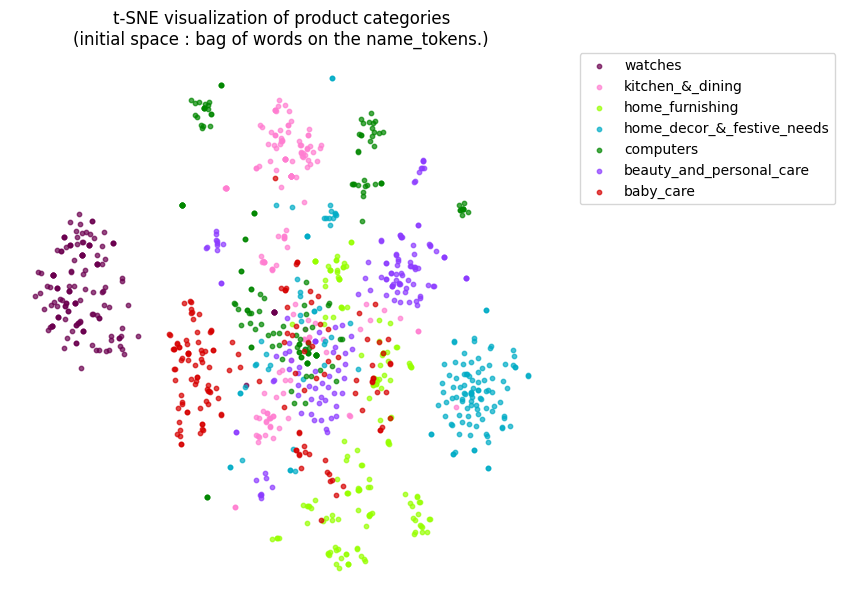

In [5]:
tsne = TSNE(n_components=2, perplexity=85, init='random')
X_tsne_bow = tsne.fit_transform(X_bow)

ds.display_tsne(
    X_tsne_bow,
    illustrative_var=df.category,
    title=('t-SNE visualization of product categories\n(initial space : '
           'bag of words on the name_tokens.)')
)

## 6.2.  [&#9650;](#toc0_) <a id='toc6_2_'></a>Tf-idf

15
30
50
70
85
100


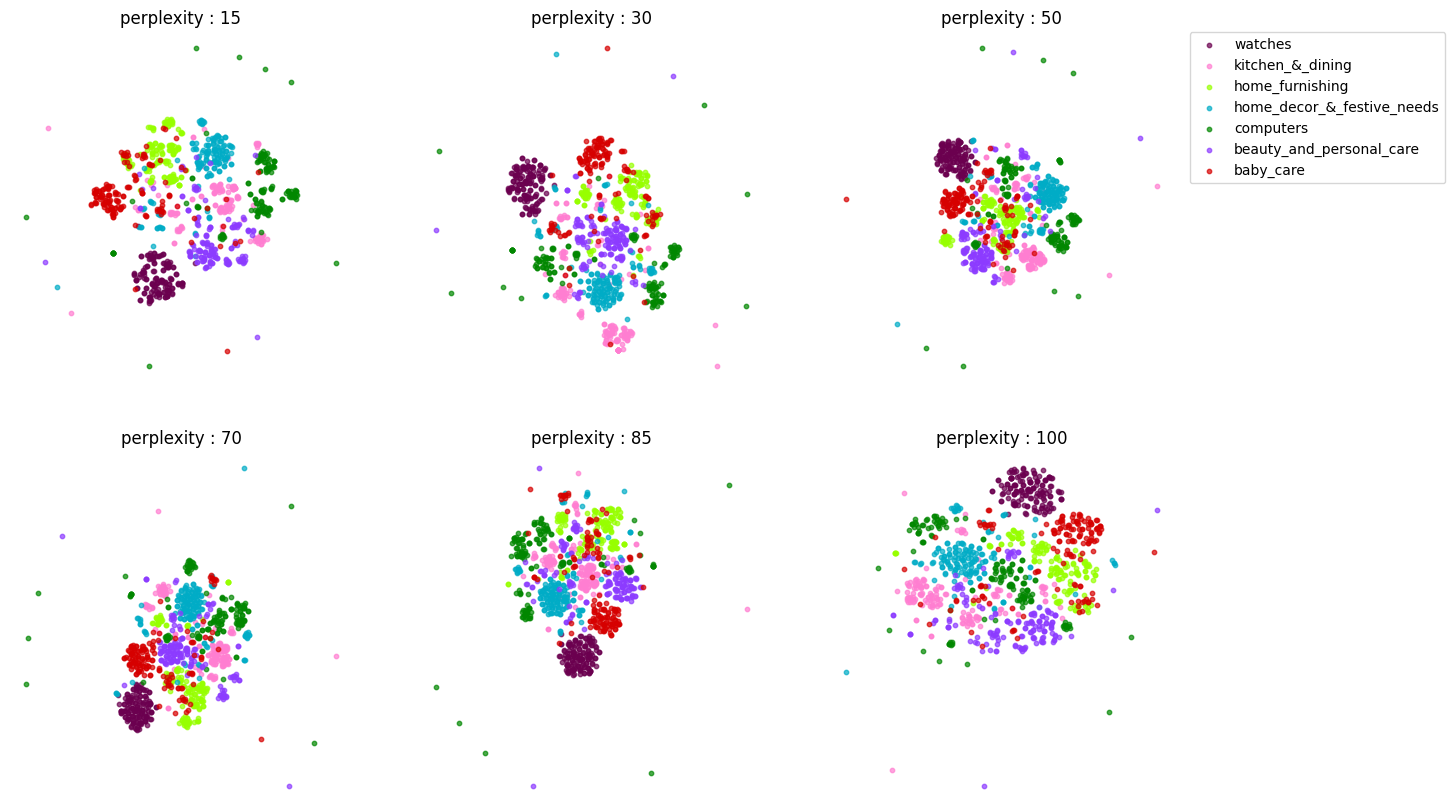

In [212]:
ds.find_tsne_best_perplexity(X_tf_idf, labels=df.category, tsne_init='random')

90
95
100
105
110
115


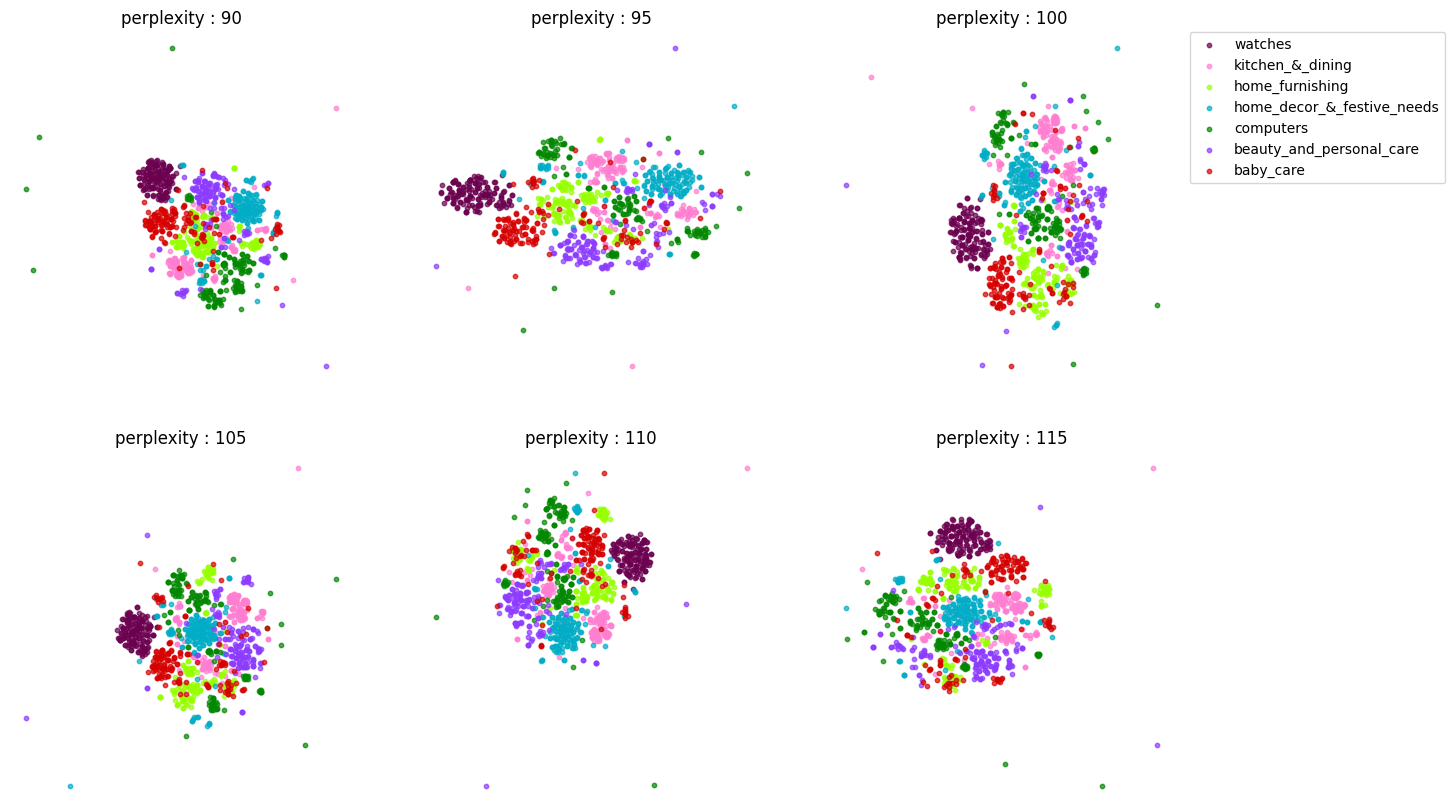

In [216]:
ds.find_tsne_best_perplexity(
    X_tf_idf,
    perplexities=np.arange(90, 120, 5),
    labels=df.category,
    tsne_init='random'
)

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=70, init='random')
X_tsne_tf_idf = tsne.fit_transform(X_tf_idf)

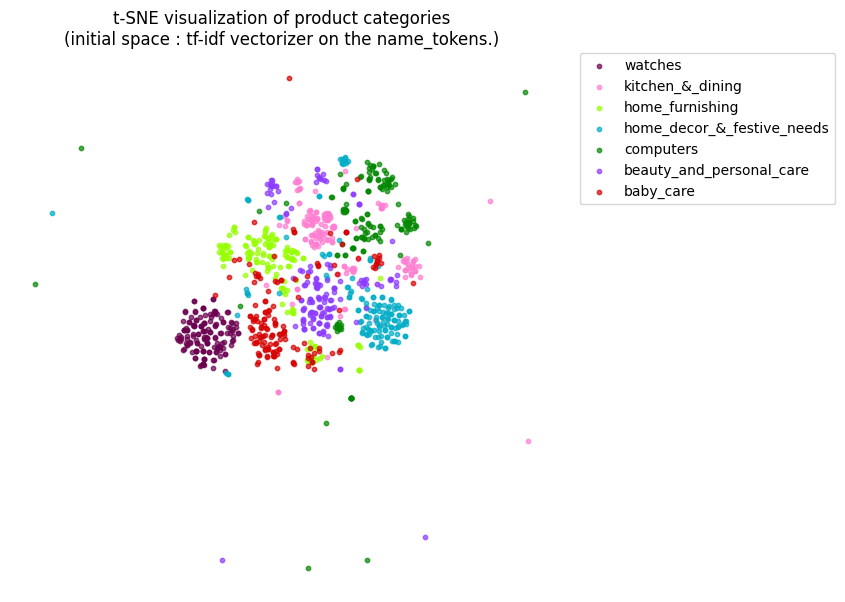

In [7]:
ds.display_tsne(
    X_tsne_tf_idf,
    illustrative_var=df.category,
    title=('t-SNE visualization of product categories\n(initial space : '
           'tf-idf vectorizer on the name_tokens.)')
)

## 6.3.  [&#9650;](#toc0_) <a id='toc6_3_'></a>Both for visual comparison.

Let's subplot it for comparison :

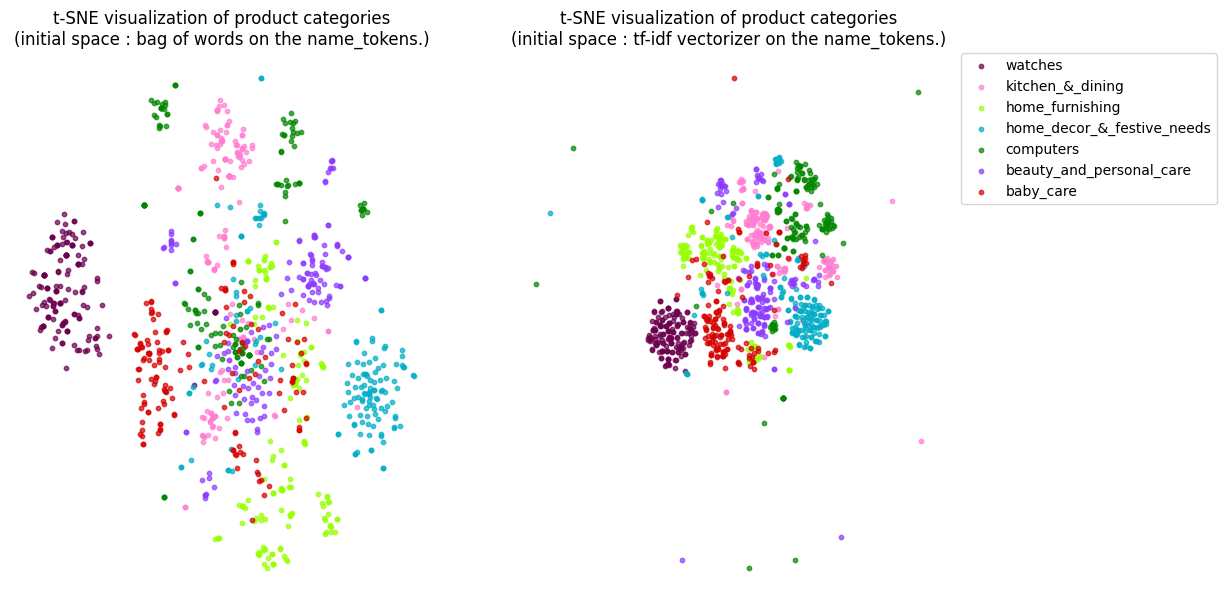

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,7))

titles = [
    (
        't-SNE visualization of product categories\n(initial space : '
        'bag of words on the name_tokens.)'
    ),
    
    (
        't-SNE visualization of product categories\n(initial space : '
        'tf-idf vectorizer on the name_tokens.)'
    )
]

for n, (X_tsne, ax, title) in enumerate(
    zip(
            [X_tsne_bow, X_tsne_tf_idf],
            ax,
            titles,
    )
):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=df.category,
        alpha=0.7,
        palette=None,
        title=title,
    )
    if n!=1:
        ax.get_legend().remove()


In both cases, we see structures.

It is likely that we are going to be able to classify products.

It is hard to tell which one is the best, but in the central part, the tf-idf seem to help the t-SNE find more similarities.

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a> Clustering with Kmeans in word-vector-space and comparison with real classes.

In [29]:
kmeans_bow = KMeans(n_clusters=7, n_init=10)
# X_bow_pp = StandardScaler().fit_transform(X_bow.toarray())
df['label_kmeans_X_bow'] = kmeans_bow.fit_predict(X_bow)

kmeans_tf_idf = KMeans(n_clusters=7, n_init=10)
# X_tf_idf_pp = StandardScaler().fit_transform(X_tf_idf.toarray())
df['label_kmeans_X_tf_idf'] = kmeans_tf_idf.fit_predict(X_tf_idf)

In [12]:
df[['category', 'label_kmeans_X_bow', 'label_kmeans_X_tf_idf']].sample(30)

,category,label_kmeans_X_bow,label_kmeans_X_tf_idf
product_id,,,
6ed4eb71c0707f1d6fdddcf62562cb02,kitchen_&_dining,5,6
f69bef5db54cb4c83b2aa8d0ce829d4e,kitchen_&_dining,0,2
f7514f6068377bcaed80043a5e321131,baby_care,5,3
c0a7134d52d4aa3eb5874aef112f809f,watches,2,4
59af3731b809a25f2bf99e99f645d8dd,kitchen_&_dining,0,2
73f460cd6f3fd206902d7097a1816405,kitchen_&_dining,0,2
7d99ac27ad194bc62000c46779c42732,home_furnishing,5,6
35a68b44bef47a809314493d28535b9d,watches,2,4
5321f76936848ccc0003f6c11e923fb5,beauty_and_personal_care,5,1


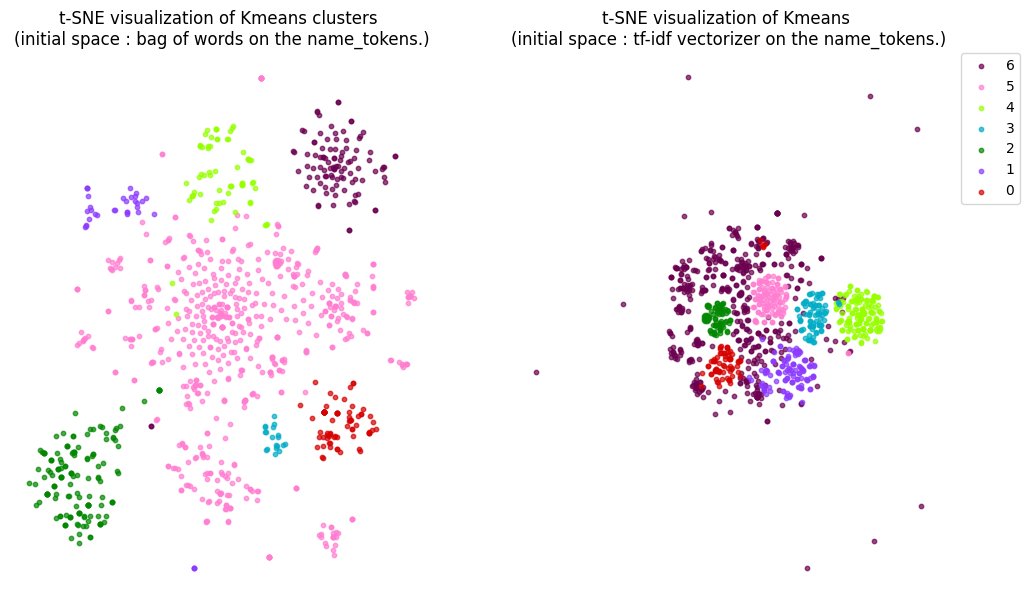

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,7))

titles = [
    (
        't-SNE visualization of Kmeans clusters \n(initial space : '
        'bag of words on the name_tokens.)'
    ),
    
    (
        't-SNE visualization of Kmeans \n(initial space : '
        'tf-idf vectorizer on the name_tokens.)'
    )
]

label_list = [df.label_kmeans_X_bow, df.label_kmeans_X_tf_idf]
myzip = zip([X_bow, X_tf_idf], ax, titles, label_list)

for n, (X, ax, title, labels) in enumerate(myzip):
    X_tsne = TSNE(perplexity=85, init='random').fit_transform(X)
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=labels,
        alpha=0.7,
        palette=None,
        title=title,
    )
    if n!=1:
        ax.get_legend().remove()

In [15]:
from itertools import combinations
from sklearn.metrics import rand_score, adjusted_rand_score

label_names = ['category', 'label_kmeans_X_bow', 'label_kmeans_X_tf_idf']
for a, b in combinations(label_names, 2):
    print(f'{a} and {b}:')
    print(f'    ARI : {adjusted_rand_score(df[a], df[b])}')
    print(f'    RI : {rand_score(df[a], df[b])}')



category and label_kmeans_X_bow:
    ARI : 0.23722858787335807
    RI : 0.6908874665214036
category and label_kmeans_X_tf_idf:
    ARI : 0.2998002771683707
    RI : 0.7765018838803396
label_kmeans_X_bow and label_kmeans_X_tf_idf:
    ARI : 0.49536887081878533
    RI : 0.7814190385401062


# 8.  [&#9650;](#toc0_) <a id='toc8_'></a> Clustering with Kmeans in the t-sne space and comparison with real classes.

In [9]:
kmeans_bow = KMeans(n_clusters=7, n_init=10)
# X_bow_pp = StandardScaler().fit_transform(X_bow.toarray())
df['label_kmeans_X_tsne_bow'] = kmeans_bow.fit_predict(X_tsne_bow)

kmeans_tf_idf = KMeans(n_clusters=7, n_init=10)
# X_tf_idf_pp = StandardScaler().fit_transform(X_tf_idf.toarray())
df['label_kmeans_X_tsne_tf_idf'] = kmeans_tf_idf.fit_predict(X_tsne_tf_idf)

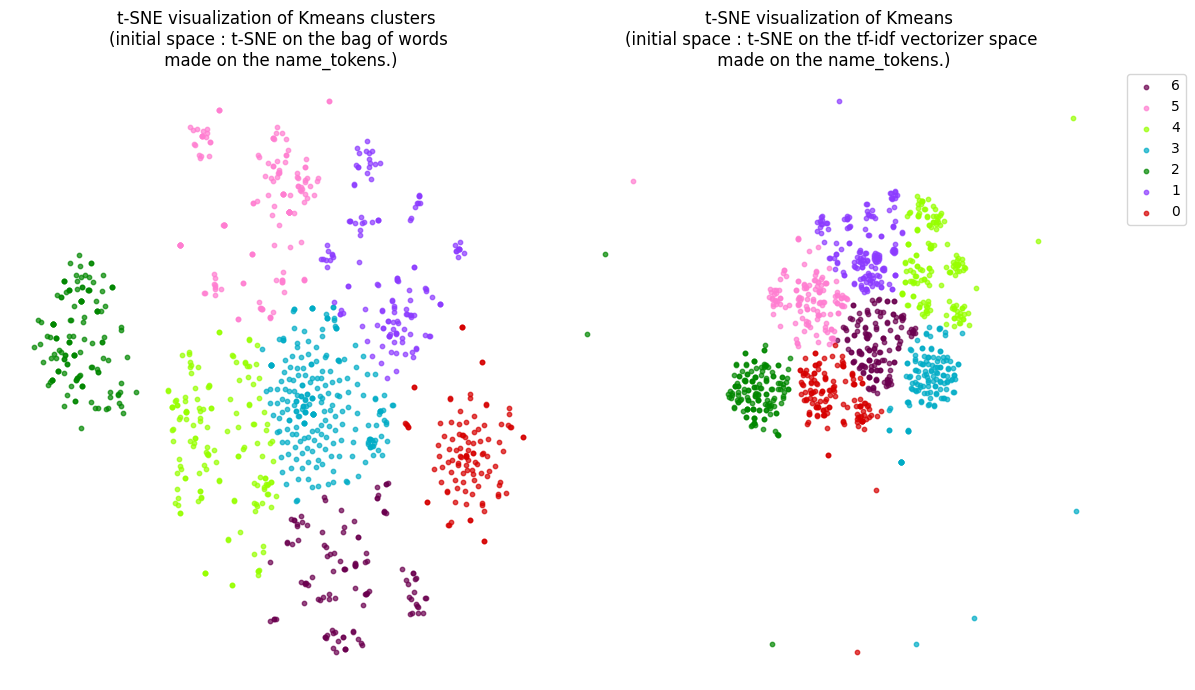

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,7))

titles = [
    (
        't-SNE visualization of Kmeans clusters \n(initial space : '
        't-SNE on the bag of words\n made on the name_tokens.)'
    ),
    
    (
        't-SNE visualization of Kmeans \n(initial space : '
        't-SNE on the tf-idf vectorizer space\n made on the name_tokens.)'
    )
]

label_list = [df.label_kmeans_X_tsne_bow, df.label_kmeans_X_tsne_tf_idf]

myzip = zip(

    [X_tsne_bow, X_tsne_tf_idf],
    ax,
    titles,
    label_list,

)

for n, (X_tsne, ax, title, labels) in enumerate(myzip):
    ds.display_tsne(
        X_tsne,
        ax=ax,
        illustrative_var=labels,
        alpha=0.7,
        palette=None,
        title=title,
    )
    if n!=1:
        ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [14]:
from itertools import combinations
from sklearn.metrics import rand_score, adjusted_rand_score

label_names = ['category',
               'label_kmeans_X_tsne_bow', 
               'label_kmeans_X_tsne_tf_idf']

for a, b in combinations(label_names, 2):
    print(f'{a} and {b}:')
    print(f'    ARI : {adjusted_rand_score(df[a], df[b])}')
    print(f'    RI : {rand_score(df[a], df[b])}')



category and label_kmeans_X_tsne_bow:
    ARI : 0.3674794366952946
    RI : 0.8415325253075492
category and label_kmeans_X_tsne_tf_idf:
    ARI : 0.47877710257813477
    RI : 0.8727804258023515
label_kmeans_X_tsne_bow and label_kmeans_X_tsne_tf_idf:
    ARI : 0.3771027347571423
    RI : 0.843731444913523


# 9.  [&#9650;](#toc0_) <a id='toc9_'></a>LDA

In [15]:
# Compute LDA dimensionality reduction on both word-vectorization
y = df.category.values
lda_bow = LinearDiscriminantAnalysis(n_components=2)
X_bow_lda = lda_bow.fit_transform(X_bow.toarray(), y)
lda_tf_idf = LinearDiscriminantAnalysis(n_components=2)
X_tf_idf_lda = lda_tf_idf.fit_transform(X_tf_idf.toarray(), y)

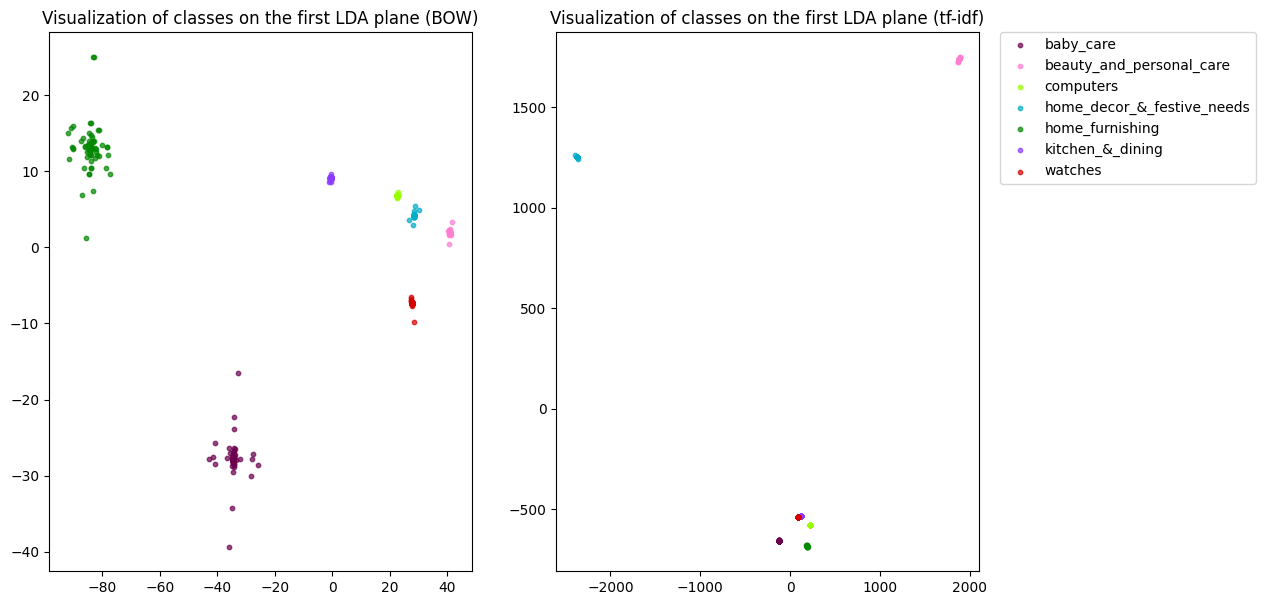

In [95]:
# Plot results
Xs = [X_bow_lda, X_tf_idf_lda]
titles = ["Visualization of classes on the first LDA plane (BOW)",
          "Visualization of classes on the first LDA plane (tf-idf)",]
fig, axs = plt.subplots(1, 2, figsize=(12,7))

n = 0
for X, ax, title in zip(Xs, axs.flat, titles):
    ds.display_2d_projection_with_illustrative_var(
        X,
        ax=ax,
        illustrative_var=df.category.values,
        title=title,
    )
    if n != 1:
        ax.get_legend().remove()
    n += 1
    
plt.show()

Amazing separation but the LDA uses the label knowledge to find the best projection axises.

Let's check if a clustering method and ARI would confirm how amazing is this separation.

# 10.  [&#9650;](#toc0_) <a id='toc10_'></a>GMM on LDA projection

In [23]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


In [ ]:


param_grid = {
    "n_components": [7],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X_bow_lda)

In [113]:
res_GMM = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
res_GMM["mean_test_score"] = -res_GMM["mean_test_score"]
res_GMM = res_GMM.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
res_GMM.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
1,7,tied,2374.394914
0,7,spherical,3814.785647
2,7,diag,4847.281791
3,7,full,5154.452154


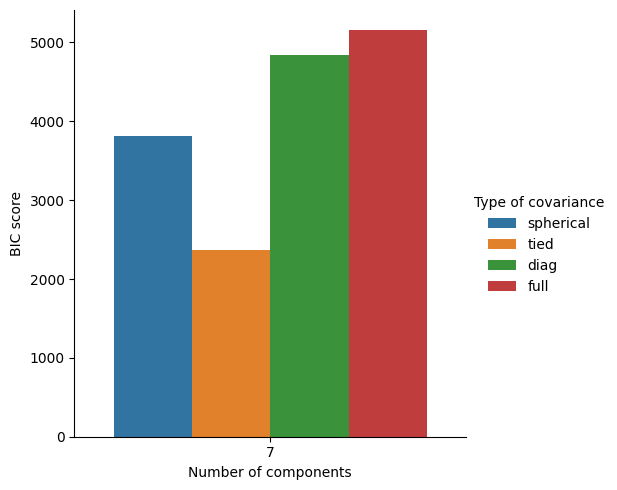

In [114]:
sns.catplot(
    data=res_GMM,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [22]:
from matplotlib.patches import Ellipse
from scipy import linalg
import colorcet as cc

colors = sns.color_palette(cc.glasbey, n_colors=7)

def make_ellipses(gmm, ax,):
    """ Extracted from the sklearn documentation.
    Make an ellipse depending on the parameter 'covariance-type'
    Because covariance matrix have different shape then. """
    # for n, color in enumerate(colors):
    for n in range(gmm.n_components):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color='gray'
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

In [128]:
Y_ = grid_search.predict(X_bow_lda)
df['label_GMM_X_bow'] = Y_

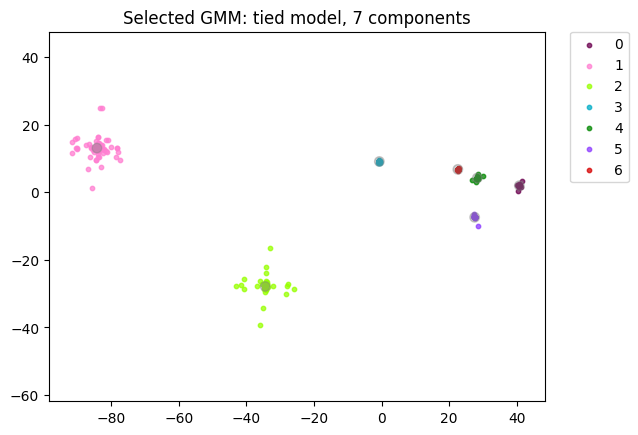

In [129]:
fig, ax = plt.subplots()

ds.display_2d_projection_with_illustrative_var(
    X_bow_lda,
    ax=ax,
    illustrative_var=Y_,
    alpha=0.75
)
make_ellipses(grid_search.best_estimator_, ax)



plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

In [130]:
label_names = ['category', 'label_GMM_X_bow']
for a, b in combinations(label_names, 2):
    print(f'{a} and {b}:')
    print(f'    ARI : {adjusted_rand_score(df[a], df[b])}')
    print(f'    RI : {rand_score(df[a], df[b])}')

category and label_GMM_X_bow:
    ARI : 1.0
    RI : 1.0


Here, I reach a perfect results, but this uses the a priori knowledge of all the classes to find the best axises for projecting the data. 

To be more realistic, I will, in the next section, do the same work, but with cross-validation, in order to change train sets and evaluate how it affects prediction on the test sets.

# 11.  [&#9650;](#toc0_) <a id='toc11_'></a>Build an LDA dimensionality reduction based on partial information of classes (using CV), and then cluster in that space.

In [19]:
from sklearn.model_selection import KFold

In [16]:
type(X_bow)

scipy.sparse._csr.csr_matrix

In [17]:
X_bow = X_bow.toarray()

In [23]:
# Create a k-fold iterator 
kf = KFold(n_splits=5, shuffle=True, random_state=1)
labels = np.array(df.category)


ARI = dict()
RI = dict()
LDA = dict()
X_LDA = dict()
GMM = dict()
y_pred = dict()


for n, (train_idx, test_idx) in enumerate(kf.split(X_bow, labels)):
    print(f'Fold {n}')
    # Use it to generate train and test sets. 
    X_train = X_bow[train_idx]
    X_test = X_bow[test_idx]
    y_train = labels[train_idx]
    y_test = labels[test_idx]

    # Fit LDA on train set (80% with known labels).
    lda = LinearDiscriminantAnalysis(n_components=2)
    LDA[n] = lda.fit(X_train, y_train)

    # Transform the full dataset
    X_LDA[n] = lda.transform(X_bow)

    # Search the best parameter for covariance type
    param_grid = {
    "n_components": [7],
    "covariance_type": ["spherical", "tied", "diag", "full"],
    }
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    grid_search.fit(X_LDA[n])

    GMM[n] = grid_search.best_estimator_

    # Predict labels and save it in the main df.
    label_name = f'label_GMM{n}'
    df[label_name] = GMM[n].predict(X_LDA[n])
    y_pred[n] = GMM[n].predict(X_LDA[n])


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [109]:
df.columns

Index(['name', 'description', 'category', 'name_tokens', 'n_tokens_in_name',
       'label_kmeans_X_bow', 'label_kmeans_X_tf_idf', 'label_GMM_X_bow',
       'label_GMM0', 'label_GMM1', 'label_GMM2', 'label_GMM3', 'label_GMM4'],
      dtype='object')

In [24]:
GMM_label_names = ['label_GMM0', 'label_GMM1', 'label_GMM2',
               'label_GMM3', 'label_GMM4']
for GMM_label in GMM_label_names:
    print(f'category and {GMM_label}:')
    print(f'    ARI : {adjusted_rand_score(df.category, df[GMM_label])}')
    print(f'    RI : {rand_score(df.category, df[GMM_label])}')

def label_similarity(a, b):
    print(f'{a} and {b}:')
    print(f'    ARI : {adjusted_rand_score(df[a], df[b])}')
    print(f'    RI : {rand_score(df[a], df[b])}')   


category and label_GMM0:
    ARI : 0.35314224031672303
    RI : 0.8033682872577057
category and label_GMM1:
    ARI : 0.3646712828645314
    RI : 0.7901112170320941
category and label_GMM2:
    ARI : 0.2747790360249986
    RI : 0.7287139679513369
category and label_GMM3:
    ARI : 0.2866997702764633
    RI : 0.7316682554814109
category and label_GMM4:
    ARI : 0.28225587993411905
    RI : 0.7386318035317082


LDA with fold 0


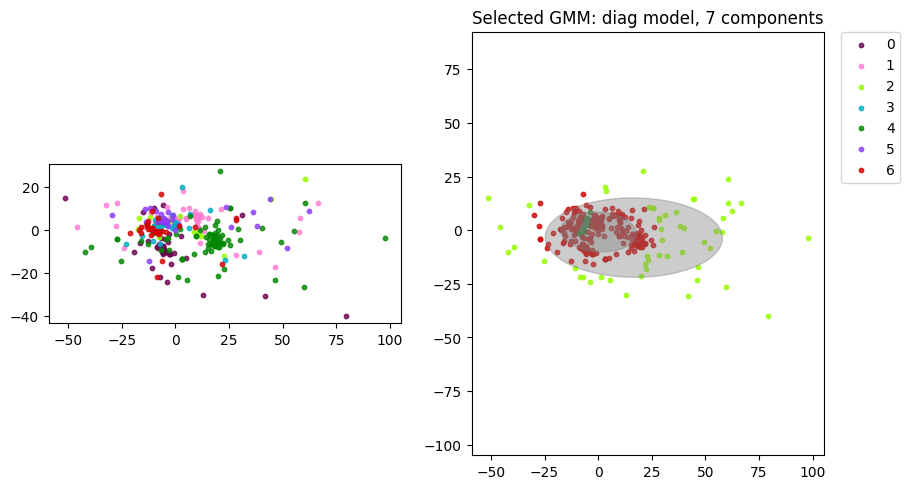

4    403
6    222
0    110
5     99
3     97
1     67
2     52
Name: count, dtype: int64

LDA with fold 1


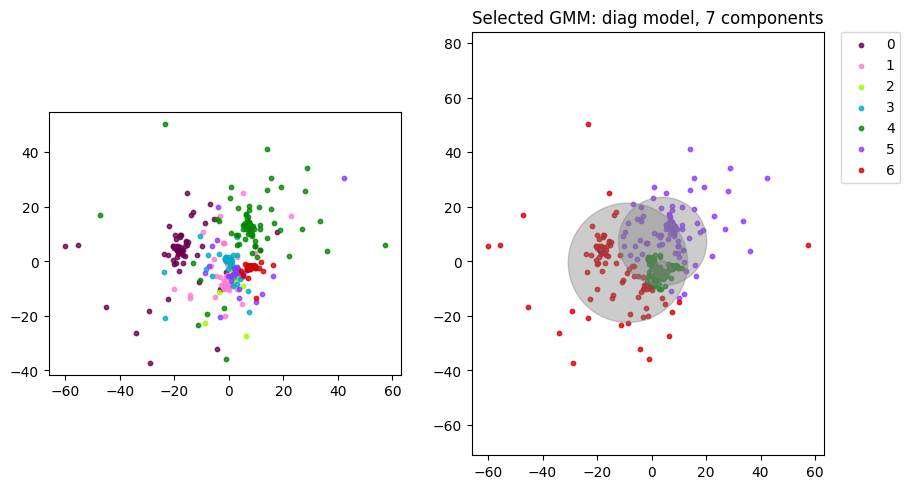

4    487
2    110
1    108
0     92
5     90
6     83
3     80
Name: count, dtype: int64

LDA with fold 2


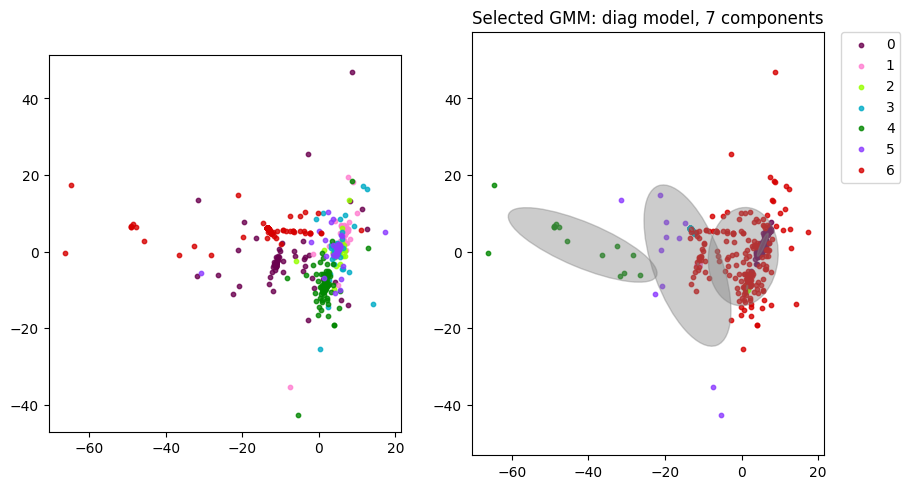

0    542
6    185
3    107
1    100
2     91
4     14
5     11
Name: count, dtype: int64

LDA with fold 3


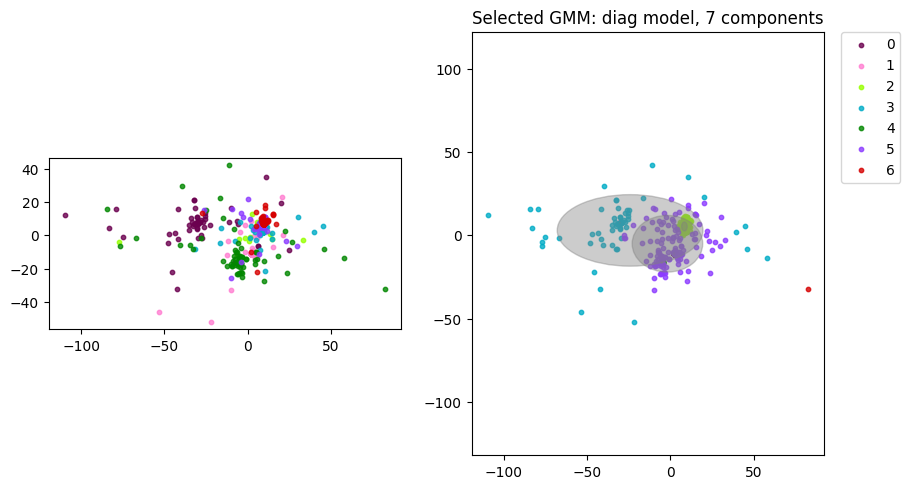

2    557
5    130
0    116
1     94
4     88
3     64
6      1
Name: count, dtype: int64

LDA with fold 4


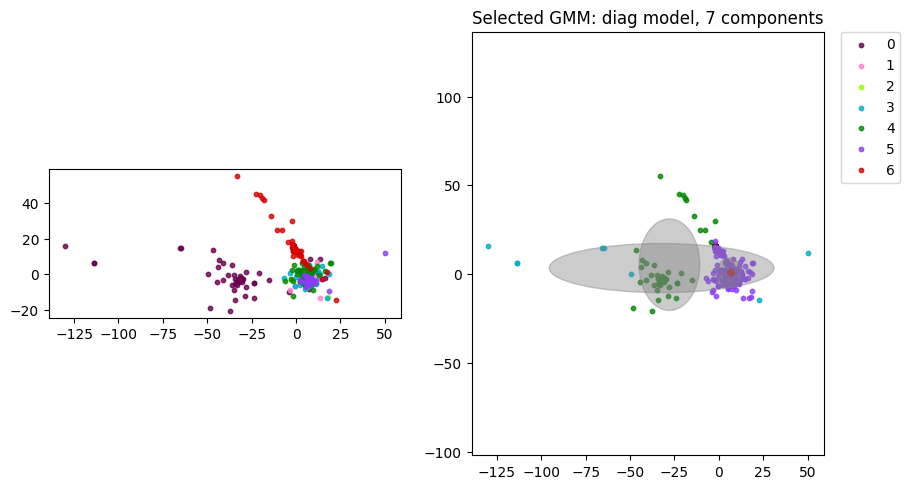

1    530
5    181
0    106
2     93
6     81
4     51
3      8
Name: count, dtype: int64

In [25]:
# Visualize projection with categories
for n in range(5):
    print(f'LDA with fold {n}')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5.5))

    # projection with actual class
    ds.display_2d_projection_with_illustrative_var(
        X_LDA[n],
        ax=ax[0],
        illustrative_var=df.category,
        alpha=0.8
    )
    ax[0].set_aspect("equal")
    ax[0].get_legend().remove()

    # projection with GMM labels and ellipses.
    ds.display_2d_projection_with_illustrative_var(
        X_LDA[n],
        ax=ax[1],
        illustrative_var=y_pred[n],
        alpha=0.8
    )
    make_ellipses(GMM[n], ax[1])
    ax[1].set_title(
        f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
        f"{grid_search.best_params_['n_components']} components"
    )
    ax[1].set_aspect("equal")
    plt.show()

    display(pd.Series(y_pred[n]).value_counts())

    
    

We see that learning the LDA's projection axises on 80% of the labelled dataset does not provide a very good plane of projection to separate the classes when we add unlabelled products. 

Therefore, The GMM does not work as well and often indicates unbalanced clusters.

Clustering on the t-SNE projection is better and does not require an a priori class label knowledge at all.

Let's see if can improve the t-SNE projection reducing the dimensionality prior its computation. 

# 12.  [&#9650;](#toc0_) <a id='toc12_'></a>Dimensionality reduction before t-SNE

## 12.1.  [&#9650;](#toc0_) <a id='toc12_1_'></a>PCA retaining 99% of the variance

### 12.1.1.  [&#9650;](#toc0_) <a id='toc12_1_1_'></a>Reduction

In [5]:
from sklearn.decomposition import PCA

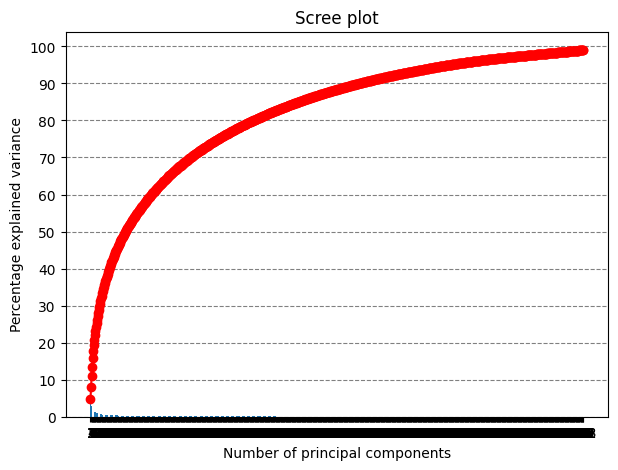

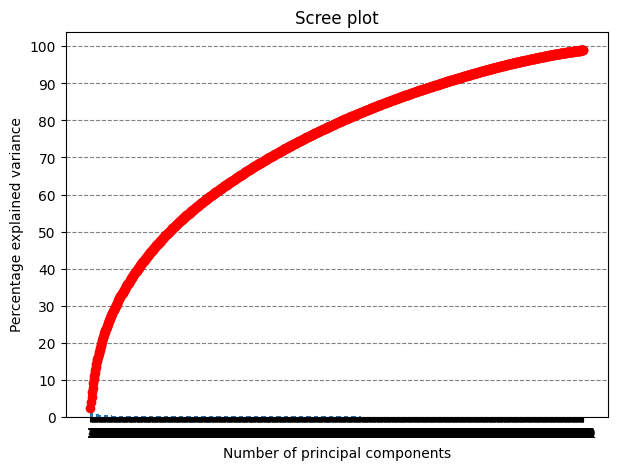

In [8]:
pca_bow = PCA(n_components=0.99)
pca_tfidf = PCA(n_components=0.99)

X_bow_pca= pca_bow.fit_transform(X_bow.toarray())
X_tfidf_pca= pca_tfidf.fit_transform(X_tf_idf.toarray())

ds.display_scree_plot(pca_bow)
ds.display_scree_plot(pca_tfidf)


In [45]:
    X_bow.shape

(1050, 2292)

In [9]:
X_bow_pca.shape

(1050, 893)

In [10]:
X_tfidf_pca.shape

(1050, 921)

### 12.1.2.  [&#9650;](#toc0_) <a id='toc12_1_2_'></a>t-SNE

In [12]:
tsne = TSNE(n_components=2, perplexity=70)

X_names = ['X_bow_pca', 'X_tfidf_pca']
var_names = ['X_tsne_bow_pca', 'X_tsne_tfidf_pca']
for X_name, var_name in zip(X_names, var_names):
    exec(var_name + f' = tsne.fit_transform({X_name})')


X_tsne_bow_pca


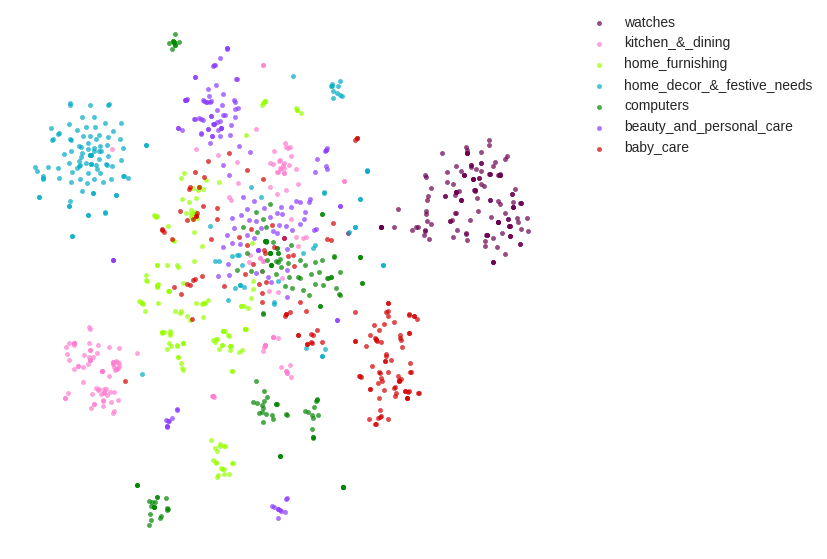

X_tsne_tfidf_pca


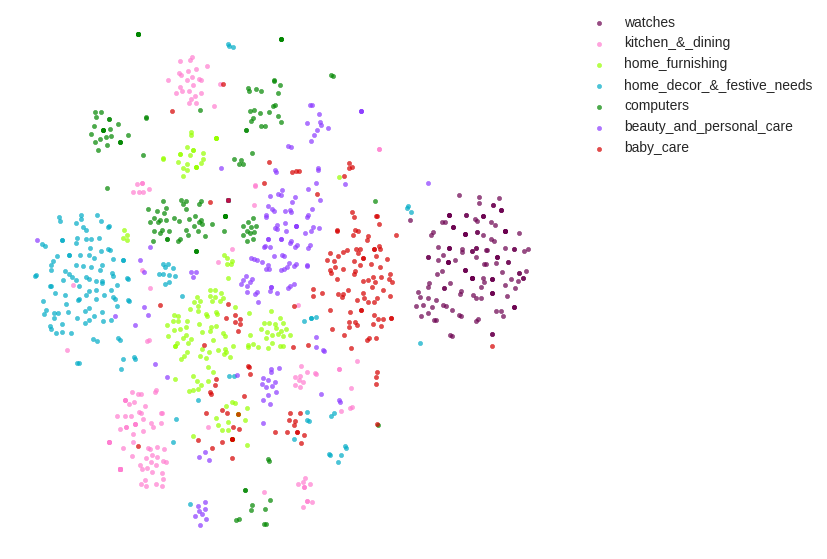

In [73]:
for var_name in var_names:
    print(var_name)
    X_tsne = eval(var_name)
    ds.display_tsne(
        X_tsne,
        illustrative_var=df.category
    )

### 12.1.3.  [&#9650;](#toc0_) <a id='toc12_1_3_'></a>KMeans on t-SNE

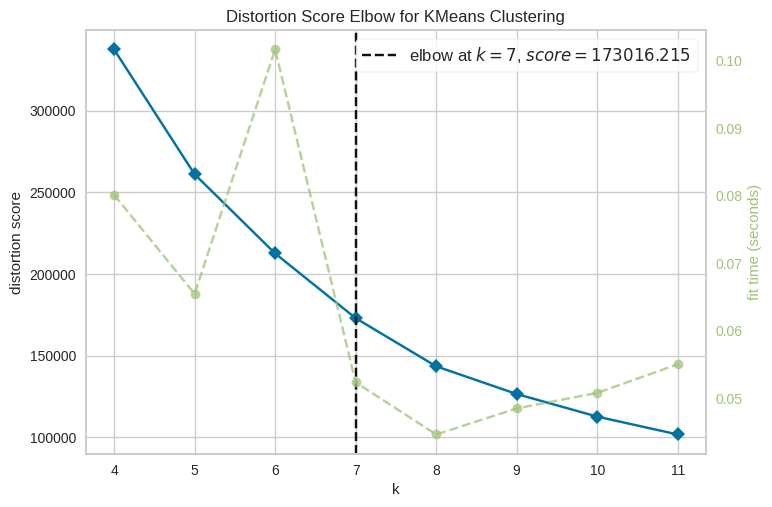

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X_tsne_tfidf_pca)       
visualizer.show()

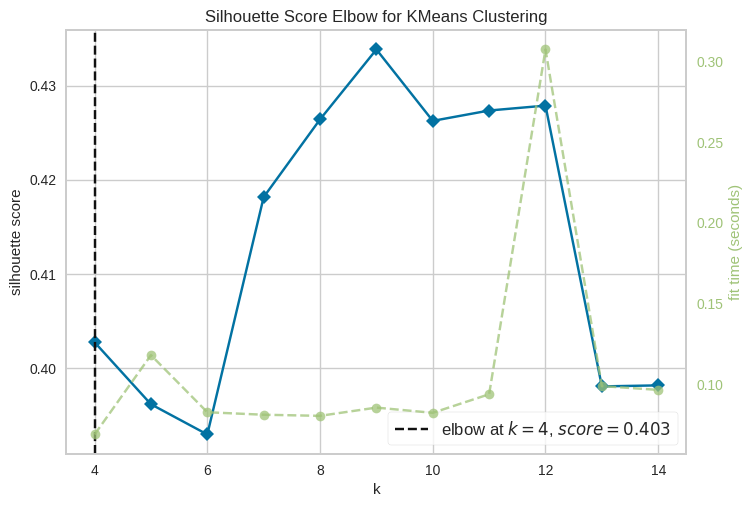

In [49]:
visualizer = KElbowVisualizer(model, k=(4,15), metric='silhouette')
visualizer.fit(X_tsne_tfidf_pca)       
visualizer.show()
plt.show()

May be I could be interesting to make 9 clusters and join some afterwards to reduce to 7 clusters.

In [15]:
kmeans = KMeans(n_clusters=7, n_init=10)
df['label_kmeans_7g_on_tsne_tfidf_pca_99'] = kmeans.fit_predict(X_tsne_tfidf_pca)

In [16]:
ds.label_similarity(df, 'category', 'label_kmeans_7g_on_tsne_tfidf_pca_99')

category and label_kmeans_7g_on_tsne_tfidf_pca_99:
    ARI : 0.39010247087194705
    RI : 0.8507403876707976


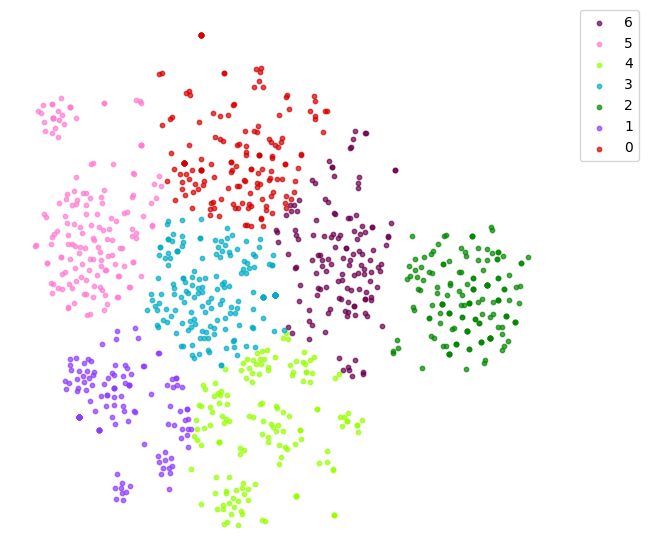

In [20]:
ds.display_tsne(
    X_tsne_tfidf_pca,
    illustrative_var=df['label_kmeans_7g_on_tsne_tfidf_pca_99'],
)

### 12.1.4.  [&#9650;](#toc0_) <a id='toc12_1_4_'></a>GMM on t-SNE

In [35]:
param_grid = {
    "n_components": [7],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X_tsne_tfidf_pca)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': [7]},
             scoring=<function gmm_bic_score at 0x7f6ac12881f0>)

In [26]:
df['label_GMM_7g_on_tsne_tfidf_pca_99'] = (grid_search
                                           .predict(X_tsne_tfidf_pca))

In [27]:
ds.label_similarity(df, 'category', 'label_GMM_7g_on_tsne_tfidf_pca_99')

category and label_GMM_7g_on_tsne_tfidf_pca_99:
    ARI : 0.3763875308498271
    RI : 0.8456961278314948


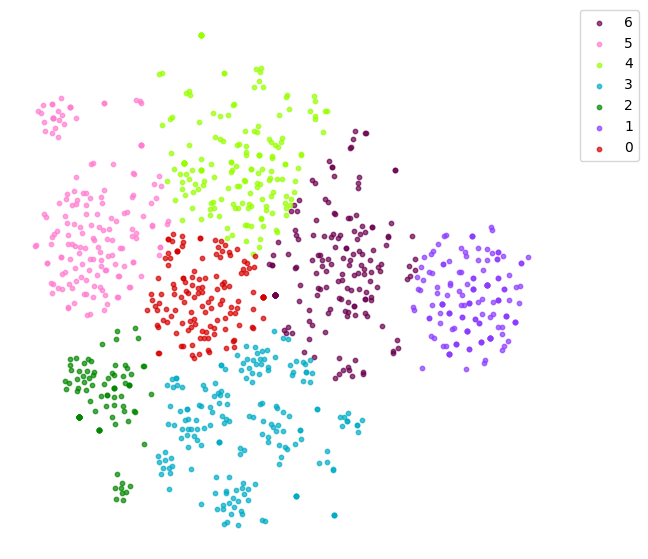

In [29]:
ds.display_tsne(
    X_tsne_tfidf_pca,
    illustrative_var=df.label_GMM_7g_on_tsne_tfidf_pca_99
)

### 12.1.5.  [&#9650;](#toc0_) <a id='toc12_1_5_'></a>Kmeans on the pca space

In [17]:
kmeans = KMeans(n_clusters=7, n_init=10)
df['label_kmeans_7g_on_tfidf_pca_99'] = kmeans.fit_predict(X_tfidf_pca)

In [18]:
ds.label_similarity(df, 'category', 'label_kmeans_7g_on_tfidf_pca_99')

category and label_kmeans_7g_on_tfidf_pca_99:
    ARI : 0.2671038654559355
    RI : 0.7329483862181669


### 12.1.6.  [&#9650;](#toc0_) <a id='toc12_1_6_'></a>GMM on the PCA space

In [36]:
param_grid = {
    "n_components": [7],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X_tfidf_pca)

df['label_GMM_7g_on_tfidf_pca_99'] = (grid_search
                                      .predict(X_tfidf_pca))


category and label_GMM_7g_on_tfidf_pca_99:
    ARI : 0.24635627718522793
    RI : 0.7125679785736984


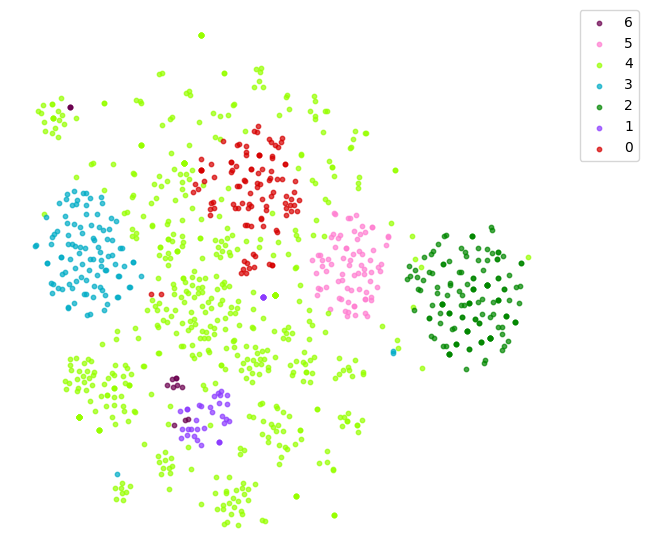

In [37]:
ds.label_similarity(df, 'category', 'label_GMM_7g_on_tfidf_pca_99')
ds.display_tsne(
    X_tsne_tfidf_pca,
    illustrative_var=df.label_GMM_7g_on_tfidf_pca_99
)

Fitting GMM in these conditions yields to very unstable results. (3 runs gave 3 totally different results) and the scores are bad.

## 12.2.  [&#9650;](#toc0_) <a id='toc12_2_'></a>LSA + KMeans

Latent Semantic Analysis is a well-know technique of the text mining literature.

It consists of applying truncated SVD on the tf-idf matrix (which is a sparse matrix) and should give better results than the PCA. 

In [51]:
lsa = make_pipeline(TruncatedSVD(n_components=200), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tf_idf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 56.3%


In [56]:
kmeans = KMeans(n_clusters=7, n_init=5)
df['label_kmeans_7g_on_lsa'] = kmeans.fit_predict(X_lsa)

In [57]:
ds.label_similarity(df, 'category', 'label_kmeans_7g_on_lsa')

category and label_kmeans_7g_on_lsa:
    ARI : 0.37663847173175774
    RI : 0.8187461981932906


# 13.  [&#9650;](#toc0_) <a id='toc13_'></a>Conclusion on that notebook.

- t-SNE embeddings are strong arguments to ensure we might be able to perform a decent labelling with clustering methods.
- Focusing only on the name of the product, we sometime have very few information (2 tokens)
- Running multiple times clustering algorithms show quite a lot of variability.
- This notebook lacks a tool that takes this variability into account and provide an easy way to compare models.
- In the next notebook, I'll use such a tool found on an [sklearn notebook](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html) and I will work on the (name + description) of products. 